In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 23198
INFO:tensorflow:Using local port 15933
INFO:tensorflow:Using local port 19323
INFO:tensorflow:Using local port 19030
INFO:tensorflow:Using local port 24420
INFO:tensorflow:Using local port 16320
INFO:tensorflow:Using local port 15906
INFO:tensorflow:Using local port 16793
INFO:tensorflow:Using local port 22236
INFO:tensorflow:Using local port 16665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

In [4]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [5]:
dataset = dataframe.values

In [6]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

In [7]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

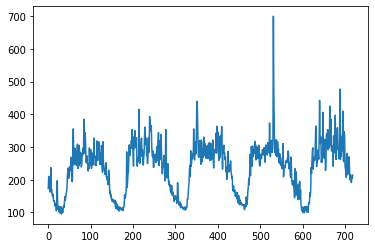

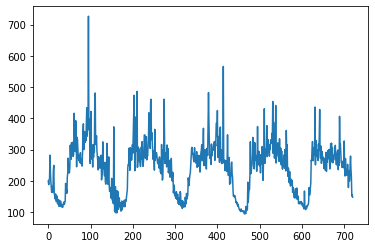

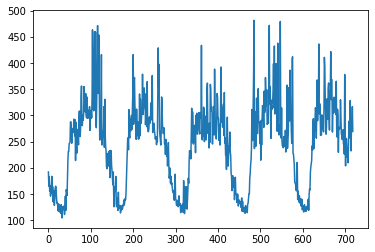

In [8]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


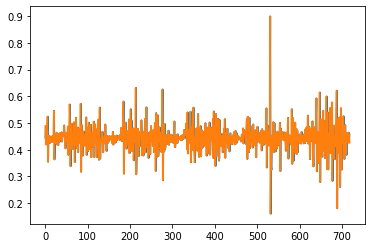

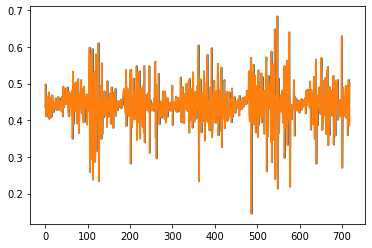

In [9]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [10]:
hunits = 2

In [11]:
lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]

    predictions.append(yhat)

count = 1
for i in range(len(test_scaled)):
    if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.15)) :
        count+=1
print('%d; %.3f; %d; %d; %.2f \n' % (hunits, 0.15, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
2; 0.150; 68; 228; 719.00 



In [12]:
lstm_model.layers[1].get_weights()
            

[array([[1.4279844],
        [1.3071604]], dtype=float32),
 array([0.18985495], dtype=float32)]

In [13]:
round(1234, -3)

1000

In [14]:
lstm_model.layers[0].get_weights()

[array([[ 0.11288723,  0.45300868, -0.6280366 , -0.6834761 ,  0.9608486 ,
         -0.49110225,  0.38863486, -0.4216674 ]], dtype=float32),
 array([[-0.22762132, -0.45006737, -0.25170344,  0.28016588, -0.31671235,
          0.16083035,  0.03614997, -0.6901451 ],
        [ 0.1710733 , -0.2598284 , -0.19185841, -0.24683803, -0.03639918,
         -0.8282335 ,  0.3352902 , -0.07595524]], dtype=float32),
 array([ 0.19809419, -0.05900069,  1.        ,  1.        ,  0.22357889,
         0.18412693,  0.20009208, -0.05566356], dtype=float32)]

In [15]:
file_object =  open('results_float_3.csv', 'w')
file_object.write("Hunit; float; Proportion; Count; Total \n")

40

In [16]:
for hunits in range(1,15):

    lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    for precision in range(1,9):
        
        for layer in lstm_model.layers:
            a = layer.get_weights()
            index = 0
            for sublayers in a:
                a[index] = np.around(sublayers, 9-precision)
                index +=1
            layer.set_weights(a)
            print(layer.get_weights())
        
        # walk-forward validation on the test data
        predictions = list()
        for i in range(len(test_scaled)):
            # make one-step forecast
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, np.around(X, 9-precision))
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            expected = raw_values[len(train) + i + 1]

            predictions.append(yhat)

        count = 1
        for i in range(len(test_scaled)):
            if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.15)) :
                count+=1
        file_object.write('%d; %d; %.2f; %d; %d \n' % (hunits, 9-precision, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.6406202, -0.9445709, -1.1837763,  1.2880328]], dtype=float32), array([[-0.20636453,  0.2379003 , -0.94850093,  0.0341067 ]],
      dtype=float32), array([ 0.55655533,  1.        , -0.51463056,  0.5737872 ], dtype=float32)]
[array([[-0.39215443]], dtype=float32), array([0.29524198], dtype=float32)]
[array([[ 0.6406202, -0.9445709, -1.1837763,  1.2880328]], dtype=float32), array([[-0.2063645,  0.2379003, -0.9485009,  0.0341067]], dtype=float32), array([ 0.5565554,  1.       , -0.5146306,  0.5

[array([[-0.5700462,  0.7802468,  0.8983889,  0.1954661,  0.3303745,
         0.4151808, -0.1635378,  0.5361533, -0.6371432, -0.4808994,
         0.0862388,  0.6650076]], dtype=float32), array([[ 0.3060801, -0.456112 ,  0.3409679,  0.0668385,  0.3017774,
        -0.0701112,  0.4343896, -0.1748472, -0.1741974,  0.3968268,
         0.0058266,  0.2728531],
       [-0.1296385, -0.2292739, -0.3968776,  0.259566 ,  0.388137 ,
         0.0454029,  0.0622718, -0.3302798,  0.0783253, -0.4660794,
         0.4272334,  0.1848609],
       [-0.0768327,  0.1856874,  0.0245158, -0.6171836,  0.2077402,
         0.2095093,  0.4405721, -0.1825929, -0.3228274, -0.2704865,
        -0.0532323, -0.2887769]], dtype=float32), array([ 0.0702962,  0.2099189,  0.3150103,  1.       ,  1.       ,
        1.       ,  0.2396421,  0.1958404, -0.2760743,  0.0717796,
        0.1856966,  0.3068263], dtype=float32)]
[array([[ 0.5953336],
       [ 0.1615404],
       [-0.7808004]], dtype=float32), array([0.2327916], dtype=f

[array([[ 0.393232,  0.39066 ,  0.315383, -0.223781,  0.124405, -0.313771,
        -0.019291, -0.127434,  0.335923, -0.106201,  0.680873, -0.061212,
        -0.197972,  0.370998,  0.302078,  0.241236]], dtype=float32), array([[-0.148067,  0.024706, -0.32199 , -0.15702 ,  0.402556, -0.083145,
        -0.143942,  0.169253,  0.158665, -0.165298, -0.284286, -0.07536 ,
         0.279426,  0.223781,  0.373669,  0.473309],
       [ 0.378093, -0.094896, -0.276191, -0.014827, -0.047603, -0.13627 ,
         0.106195,  0.436699, -0.12592 , -0.246353, -0.315042,  0.371444,
        -0.042191,  0.291732, -0.127754, -0.362965],
       [-0.059362,  0.06754 , -0.125733, -0.032932, -0.198631,  0.056946,
        -0.039765,  0.052544, -0.493972,  0.302494, -0.133428,  0.496795,
         0.259836, -0.369151, -0.037283,  0.350266],
       [-0.188096,  0.033147,  0.124805, -0.23435 ,  0.068123,  0.356489,
         0.18774 ,  0.23649 ,  0.570493,  0.314562, -0.151972,  0.244929,
         0.051063,  0.047433, 

[array([[ 0.0008715, -0.4188544,  0.5594585,  0.8094658,  0.1041429,
         0.4111611, -0.3826996,  0.4317172,  0.0935646,  0.3913537,
        -0.3323623, -0.1055787,  0.1645849, -0.4965765, -0.0594363,
        -0.1865868,  0.3681463,  0.0098204,  0.3669978,  0.3577077]],
      dtype=float32), array([[-2.605814e-01,  1.081180e-02,  1.160797e-01,  4.309872e-01,
        -1.290740e-01, -4.494241e-01,  8.727430e-02,  3.749780e-02,
        -1.772000e-04, -3.312589e-01,  7.597030e-02,  3.587900e-02,
         1.739984e-01,  1.068108e-01,  2.738600e-01, -9.283940e-02,
        -3.806779e-01, -3.201378e-01,  5.709340e-02, -1.110583e-01],
       [-1.022918e-01,  3.530180e-01,  2.562466e-01, -5.107390e-02,
         2.202374e-01, -1.292128e-01,  1.777618e-01, -1.941362e-01,
        -2.200390e-01,  1.662070e-02, -4.504768e-01, -4.353600e-01,
        -8.849930e-02,  2.208535e-01, -3.091080e-01, -8.107000e-02,
        -9.711500e-02, -9.478380e-02, -1.969225e-01,  7.121660e-02],
       [-3.504000e-04

[array([[ 0.001, -0.419,  0.56 ,  0.81 ,  0.104,  0.411, -0.383,  0.432,
         0.094,  0.391, -0.332, -0.106,  0.165, -0.497, -0.059, -0.187,
         0.368,  0.01 ,  0.367,  0.358]], dtype=float32), array([[-0.261,  0.011,  0.116,  0.431, -0.129, -0.449,  0.087,  0.038,
        -0.   , -0.331,  0.076,  0.036,  0.174,  0.107,  0.274, -0.093,
        -0.381, -0.32 ,  0.057, -0.111],
       [-0.102,  0.353,  0.256, -0.051,  0.22 , -0.129,  0.178, -0.194,
        -0.22 ,  0.017, -0.45 , -0.435, -0.088,  0.221, -0.309, -0.081,
        -0.097, -0.095, -0.197,  0.071],
       [-0.   , -0.041,  0.325, -0.073,  0.176, -0.039, -0.713,  0.02 ,
        -0.267,  0.049,  0.042,  0.216,  0.067,  0.239, -0.043, -0.075,
        -0.301,  0.252,  0.027,  0.016],
       [ 0.087,  0.121,  0.212,  0.05 ,  0.023,  0.256,  0.277,  0.04 ,
         0.13 ,  0.082, -0.281,  0.246,  0.012, -0.194,  0.372,  0.074,
        -0.437,  0.257, -0.135,  0.408],
       [-0.05 ,  0.308,  0.123,  0.165, -0.225,  0.262, -

[array([[ 0.020452, -0.010503, -0.03569 , -0.270104,  0.208929,  0.193341,
        -0.325815,  0.245904,  0.158435,  0.017338,  0.30974 ,  0.302849,
         0.524335,  0.084188,  0.158392,  0.34923 ,  0.216171, -0.011856,
        -0.096128, -0.465951,  0.491702, -0.084415, -0.497802,  0.106781]],
      dtype=float32), array([[ 0.262286,  0.134448, -0.264238, -0.206242,  0.01901 ,  0.054226,
        -0.184204, -0.171223,  0.182429, -0.322508,  0.203629, -0.082913,
         0.056841,  0.191021, -0.14454 , -0.336625, -0.291965,  0.355865,
         0.14688 , -0.059174,  0.235623,  0.260525, -0.074047,  0.093964],
       [-0.147741,  0.085605,  0.261993, -0.300527,  0.018092, -0.084103,
         0.00433 , -0.032392,  0.020019, -0.154546, -0.273884,  0.259836,
         0.368733,  0.242701, -0.088812,  0.191674, -0.094343,  0.028151,
        -0.437934,  0.053857, -0.176823,  0.380053, -0.11001 ,  0.07017 ],
       [-0.169661,  0.146597,  0.048788, -0.286935,  0.070673, -0.056634,
        -0.

[array([[ 0.02, -0.01, -0.04, -0.27,  0.21,  0.19, -0.33,  0.25,  0.16,
         0.02,  0.31,  0.3 ,  0.52,  0.08,  0.16,  0.35,  0.22, -0.01,
        -0.1 , -0.47,  0.49, -0.08, -0.5 ,  0.11]], dtype=float32), array([[ 0.26,  0.13, -0.26, -0.21,  0.02,  0.05, -0.18, -0.17,  0.18,
        -0.32,  0.2 , -0.08,  0.06,  0.19, -0.14, -0.34, -0.29,  0.36,
         0.15, -0.06,  0.24,  0.26, -0.07,  0.09],
       [-0.15,  0.09,  0.26, -0.3 ,  0.02, -0.08,  0.  , -0.03,  0.02,
        -0.16, -0.27,  0.26,  0.37,  0.24, -0.09,  0.19, -0.09,  0.03,
        -0.44,  0.05, -0.18,  0.38, -0.11,  0.07],
       [-0.17,  0.15,  0.05, -0.29,  0.07, -0.06, -0.04,  0.05, -0.06,
        -0.54,  0.06,  0.17, -0.27,  0.02, -0.02, -0.31,  0.13, -0.48,
        -0.12,  0.07,  0.12, -0.27,  0.01, -0.06],
       [ 0.27,  0.42,  0.06,  0.12,  0.14, -0.1 ,  0.21, -0.42, -0.24,
         0.33,  0.1 ,  0.26, -0.05,  0.1 ,  0.12, -0.02, -0.06, -0.23,
        -0.09, -0.01,  0.3 ,  0.04, -0.09,  0.19],
       [-0.23,  0

[array([[-2.26408e-01,  1.40078e-01, -1.44010e-01, -1.59341e-01,
        -4.92303e-01,  2.80798e-01,  1.04444e-01, -1.62000e-04,
        -3.31064e-01,  4.58680e-02,  2.04484e-01,  4.47350e-01,
        -3.91035e-01, -3.02721e-01, -1.97559e-01, -1.37184e-01,
        -2.52522e-01, -4.03524e-01,  2.68081e-01,  2.17867e-01,
        -1.93362e-01,  2.94770e-01,  1.08136e-01,  1.17645e-01,
         3.88587e-01,  6.01700e-02,  7.07053e-01,  2.65513e-01]],
      dtype=float32), array([[-0.106658, -0.156108,  0.210689, -0.363875, -0.171047,  0.091966,
        -0.162586, -0.074354, -0.097206,  0.001848, -0.01621 , -0.115924,
        -0.102218, -0.344538, -0.036816, -0.234466, -0.077745,  0.175727,
        -0.21512 ,  0.001855, -0.46047 , -0.169195,  0.029035, -0.248506,
         0.284053,  0.13571 , -0.119187,  0.096819],
       [-0.064522, -0.111422,  0.103178, -0.06815 , -0.294029,  0.196912,
         0.098044,  0.017739, -0.260665,  0.006581, -0.116846, -0.133068,
         0.169833,  0.114473, 

[array([[-0.226,  0.14 , -0.144, -0.159, -0.492,  0.281,  0.104, -0.   ,
        -0.331,  0.046,  0.204,  0.447, -0.391, -0.303, -0.198, -0.137,
        -0.252, -0.404,  0.268,  0.218, -0.193,  0.295,  0.108,  0.118,
         0.389,  0.06 ,  0.707,  0.266]], dtype=float32), array([[-0.107, -0.156,  0.211, -0.364, -0.171,  0.092, -0.163, -0.074,
        -0.097,  0.002, -0.016, -0.116, -0.102, -0.344, -0.037, -0.234,
        -0.078,  0.176, -0.215,  0.002, -0.46 , -0.169,  0.029, -0.248,
         0.284,  0.136, -0.119,  0.097],
       [-0.064, -0.111,  0.103, -0.068, -0.294,  0.197,  0.098,  0.018,
        -0.261,  0.007, -0.117, -0.133,  0.17 ,  0.114,  0.24 ,  0.106,
         0.144, -0.259, -0.413, -0.412,  0.255,  0.116, -0.082, -0.107,
        -0.058,  0.289,  0.097, -0.04 ],
       [-0.107,  0.024,  0.347,  0.351,  0.32 , -0.194, -0.245,  0.169,
        -0.003,  0.096,  0.066,  0.006,  0.129, -0.35 , -0.178,  0.208,
        -0.25 , -0.058, -0.078, -0.09 ,  0.046,  0.195, -0.105, -0.

[array([[ 0.3611482,  0.270263 , -0.0440784,  0.1100938,  0.3908465,
        -0.2258324, -0.3909414, -0.4105075,  0.1071304,  0.2364328,
         0.3448991,  0.2065074,  0.4062313, -0.2647489, -0.2557528,
         0.0199478, -0.2186661, -0.0228012, -0.0800565,  0.2966468,
        -0.3454822, -0.4162208,  0.2672487,  0.2285273, -0.3608627,
         0.3917806,  0.4366099,  0.3060799,  0.3508445, -0.1125958,
         0.3983512,  0.0236896]], dtype=float32), array([[-0.1660656, -0.0095858, -0.3395368,  0.2272518, -0.0530614,
        -0.0103624, -0.3071638,  0.0540304,  0.1793066,  0.417312 ,
         0.1158242, -0.0286473,  0.3790766,  0.0444261,  0.0565086,
        -0.1081034,  0.0395388,  0.242909 , -0.0997953,  0.2073342,
        -0.1273723, -0.0578934,  0.1815617,  0.2552408,  0.0551177,
         0.0486643,  0.0600079,  0.0607422,  0.1630421, -0.1660713,
        -0.1211152, -0.1067275],
       [-0.0103733,  0.2447284, -0.2838755, -0.1583831,  0.0102735,
        -0.1239669,  0.2524787, 

[array([[ 0.36115,  0.27026, -0.04408,  0.11009,  0.39085, -0.22583,
        -0.39094, -0.41051,  0.10713,  0.23643,  0.3449 ,  0.20651,
         0.40623, -0.26475, -0.25575,  0.01995, -0.21867, -0.0228 ,
        -0.08006,  0.29665, -0.34548, -0.41622,  0.26725,  0.22853,
        -0.36086,  0.39178,  0.43661,  0.30608,  0.35084, -0.1126 ,
         0.39835,  0.02369]], dtype=float32), array([[-0.16607, -0.00959, -0.33954,  0.22725, -0.05306, -0.01036,
        -0.30716,  0.05403,  0.17931,  0.41731,  0.11582, -0.02865,
         0.37908,  0.04443,  0.05651, -0.1081 ,  0.03954,  0.24291,
        -0.0998 ,  0.20733, -0.12737, -0.05789,  0.18156,  0.25524,
         0.05512,  0.04866,  0.06001,  0.06074,  0.16304, -0.16607,
        -0.12112, -0.10673],
       [-0.01037,  0.24473, -0.28388, -0.15838,  0.01027, -0.12397,
         0.25248,  0.14854, -0.03965,  0.0336 , -0.08088,  0.11784,
         0.15605, -0.27267, -0.07638, -0.00097, -0.05005, -0.01206,
        -0.14271, -0.30748, -0.15708, -0

[array([[ 0.36,  0.27, -0.04,  0.11,  0.39, -0.23, -0.39, -0.41,  0.11,
         0.24,  0.34,  0.21,  0.41, -0.26, -0.26,  0.02, -0.22, -0.02,
        -0.08,  0.3 , -0.35, -0.42,  0.27,  0.23, -0.36,  0.39,  0.44,
         0.31,  0.35, -0.11,  0.4 ,  0.02]], dtype=float32), array([[-0.17, -0.01, -0.34,  0.23, -0.05, -0.01, -0.31,  0.05,  0.18,
         0.42,  0.12, -0.03,  0.38,  0.04,  0.06, -0.11,  0.04,  0.24,
        -0.1 ,  0.21, -0.13, -0.06,  0.18,  0.26,  0.06,  0.05,  0.06,
         0.06,  0.16, -0.17, -0.12, -0.11],
       [-0.01,  0.24, -0.28, -0.16,  0.01, -0.12,  0.25,  0.15, -0.04,
         0.03, -0.08,  0.12,  0.16, -0.27, -0.08, -0.  , -0.05, -0.01,
        -0.14, -0.31, -0.16, -0.15,  0.09, -0.37, -0.02, -0.21,  0.28,
        -0.18,  0.08, -0.34,  0.04, -0.14],
       [-0.23, -0.13,  0.  , -0.02, -0.42, -0.03,  0.02,  0.24, -0.17,
        -0.22,  0.03, -0.05,  0.11, -0.02, -0.08,  0.23, -0.08, -0.43,
        -0.14,  0.22,  0.14,  0.04, -0.17,  0.32, -0.06, -0.08,  0.04

[array([[-0.1628939, -0.2730716, -0.1385933,  0.2942605, -0.1387394,
        -0.148971 , -0.1624034,  0.1926629,  0.4081389, -0.023335 ,
        -0.0713158, -0.1179558, -0.1985266, -0.0014333,  0.275792 ,
        -0.2627652, -0.0302779,  0.0825816, -0.1956616,  0.1407333,
        -0.3724865, -0.2702518, -0.1729279, -0.4324844, -0.3008918,
         0.0754901,  0.4443237,  0.1210484, -0.3495697, -0.2150405,
         0.1923003,  0.3860729,  0.3644061, -0.2615584,  0.1343105,
        -0.1538356]], dtype=float32), array([[-1.831512e-01, -3.889910e-02,  2.017550e-01,  1.060073e-01,
        -1.348544e-01,  2.607992e-01,  1.107684e-01, -3.590920e-02,
         1.385826e-01,  8.019810e-02, -1.061686e-01,  1.778687e-01,
         1.891584e-01, -2.981888e-01,  1.438355e-01, -1.860464e-01,
         2.206280e-01, -1.424362e-01, -1.347270e-01, -2.303390e-02,
         1.591659e-01,  1.111972e-01,  7.005160e-02,  2.252966e-01,
        -9.785530e-02, -3.537307e-01, -2.311220e-01,  1.114221e-01,
         

[array([[-0.16289, -0.27307, -0.13859,  0.29426, -0.13874, -0.14897,
        -0.1624 ,  0.19266,  0.40814, -0.02334, -0.07132, -0.11796,
        -0.19853, -0.00143,  0.27579, -0.26276, -0.03028,  0.08258,
        -0.19566,  0.14073, -0.37249, -0.27025, -0.17293, -0.43248,
        -0.30089,  0.07549,  0.44432,  0.12105, -0.34957, -0.21504,
         0.1923 ,  0.38607,  0.36441, -0.26156,  0.13431, -0.15384]],
      dtype=float32), array([[-1.8315e-01, -3.8900e-02,  2.0176e-01,  1.0601e-01, -1.3485e-01,
         2.6080e-01,  1.1077e-01, -3.5910e-02,  1.3858e-01,  8.0200e-02,
        -1.0617e-01,  1.7787e-01,  1.8916e-01, -2.9819e-01,  1.4384e-01,
        -1.8605e-01,  2.2063e-01, -1.4244e-01, -1.3473e-01, -2.3030e-02,
         1.5917e-01,  1.1120e-01,  7.0050e-02,  2.2530e-01, -9.7860e-02,
        -3.5373e-01, -2.3112e-01,  1.1142e-01,  3.8540e-02, -2.0698e-01,
         2.6366e-01, -3.9420e-02,  4.6330e-02, -1.2256e-01, -1.6443e-01,
         1.5346e-01],
       [ 8.1110e-02, -2.2003e-01, 

[array([[-0.163, -0.273, -0.139,  0.294, -0.139, -0.149, -0.162,  0.193,
         0.408, -0.023, -0.071, -0.118, -0.198, -0.001,  0.276, -0.263,
        -0.03 ,  0.083, -0.196,  0.141, -0.372, -0.27 , -0.173, -0.432,
        -0.301,  0.076,  0.444,  0.121, -0.35 , -0.215,  0.192,  0.386,
         0.364, -0.262,  0.134, -0.154]], dtype=float32), array([[-0.183, -0.039,  0.202,  0.106, -0.135,  0.261,  0.111, -0.036,
         0.139,  0.08 , -0.106,  0.178,  0.189, -0.298,  0.144, -0.186,
         0.221, -0.142, -0.135, -0.023,  0.159,  0.111,  0.07 ,  0.225,
        -0.098, -0.354, -0.231,  0.111,  0.038, -0.207,  0.264, -0.039,
         0.046, -0.123, -0.164,  0.154],
       [ 0.081, -0.22 ,  0.033, -0.239, -0.215,  0.168, -0.035,  0.283,
         0.072, -0.072,  0.116,  0.481, -0.084,  0.233, -0.133,  0.132,
        -0.252, -0.256, -0.059,  0.056, -0.044, -0.007,  0.011,  0.152,
         0.176,  0.135,  0.131,  0.063, -0.108, -0.198, -0.01 ,  0.006,
        -0.099,  0.024, -0.254,  0.1

(1439, 1, 1)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (1, 10)                   480       
_________________________________________________________________
output (Dense)               (1, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
[array([[-0.35748085,  0.0583138 , -0.16655536,  0.08748578,  0.13579093,
        -0.15762728,  0.27414292, -0.07135136, -0.11487615, -0.1302324 ,
        -0.20781799, -0.20326997, -0.22478998, -0.06586519, -0.1745325 ,
         0.30654064, -0.20877154,  0.15405914,  0.33372262,  0.3021641 ,
        -0.07536434, -0.41581813, -0.37102157, -0.06236262, -0.43267328,
        -0.12129197, -0.0739691 , -0.29095528,  0.27499637,  0.04849828,
         0.00832596,  0.06970114, -0.01861881, -0.30677184,  0.18

[array([[-0.357481,  0.058314, -0.166555,  0.087486,  0.135791, -0.157627,
         0.274143, -0.071351, -0.114876, -0.130232, -0.207818, -0.20327 ,
        -0.22479 , -0.065865, -0.174532,  0.306541, -0.208772,  0.154059,
         0.333723,  0.302164, -0.075364, -0.415818, -0.371022, -0.062363,
        -0.432673, -0.121292, -0.073969, -0.290955,  0.274996,  0.048498,
         0.008326,  0.069701, -0.018619, -0.306772,  0.182576,  0.103716,
        -0.246043,  0.394449, -0.183713, -0.109068]], dtype=float32), array([[-0.00243 , -0.08503 ,  0.060924, -0.102291, -0.003752, -0.350635,
        -0.081625,  0.030369, -0.04307 ,  0.248983,  0.160023, -0.053618,
        -0.064217, -0.139626, -0.030314, -0.176901, -0.108313, -0.148253,
        -0.104177,  0.051119,  0.116289, -0.15566 , -0.001677, -0.109189,
         0.409919,  0.075563,  0.028158, -0.152671, -0.290897, -0.113238,
        -0.470051,  0.045331, -0.177926,  0.149575, -0.048477,  0.016674,
         0.028494,  0.091457, -0.135944, 

[array([[-0.3575,  0.0583, -0.1666,  0.0875,  0.1358, -0.1576,  0.2741,
        -0.0714, -0.1149, -0.1302, -0.2078, -0.2033, -0.2248, -0.0659,
        -0.1745,  0.3065, -0.2088,  0.1541,  0.3337,  0.3022, -0.0754,
        -0.4158, -0.371 , -0.0624, -0.4327, -0.1213, -0.074 , -0.291 ,
         0.275 ,  0.0485,  0.0083,  0.0697, -0.0186, -0.3068,  0.1826,
         0.1037, -0.246 ,  0.3944, -0.1837, -0.1091]], dtype=float32), array([[-0.0024, -0.085 ,  0.0609, -0.1023, -0.0038, -0.3506, -0.0816,
         0.0304, -0.0431,  0.249 ,  0.16  , -0.0536, -0.0642, -0.1396,
        -0.0303, -0.1769, -0.1083, -0.1482, -0.1042,  0.0511,  0.1163,
        -0.1557, -0.0017, -0.1092,  0.4099,  0.0756,  0.0282, -0.1527,
        -0.2909, -0.1132, -0.47  ,  0.0453, -0.1779,  0.1496, -0.0485,
         0.0167,  0.0285,  0.0915, -0.1359,  0.0205],
       [ 0.0052, -0.305 , -0.0238,  0.0084, -0.1652,  0.2167,  0.2288,
         0.3169,  0.3051,  0.1671,  0.0149, -0.0384,  0.0254, -0.1377,
         0.231 ,  0.12

[array([[-0.36,  0.06, -0.17,  0.09,  0.14, -0.16,  0.27, -0.07, -0.12,
        -0.13, -0.21, -0.2 , -0.22, -0.07, -0.17,  0.31, -0.21,  0.15,
         0.33,  0.3 , -0.08, -0.42, -0.37, -0.06, -0.43, -0.12, -0.07,
        -0.29,  0.28,  0.05,  0.01,  0.07, -0.02, -0.31,  0.18,  0.1 ,
        -0.25,  0.39, -0.18, -0.11]], dtype=float32), array([[-0.  , -0.08,  0.06, -0.1 , -0.  , -0.35, -0.08,  0.03, -0.04,
         0.25,  0.16, -0.05, -0.06, -0.14, -0.03, -0.18, -0.11, -0.15,
        -0.1 ,  0.05,  0.12, -0.16, -0.  , -0.11,  0.41,  0.08,  0.03,
        -0.15, -0.29, -0.11, -0.47,  0.04, -0.18,  0.15, -0.05,  0.02,
         0.03,  0.09, -0.14,  0.02],
       [ 0.  , -0.3 , -0.02,  0.01, -0.16,  0.22,  0.23,  0.32,  0.3 ,
         0.17,  0.02, -0.04,  0.02, -0.14,  0.23,  0.12, -0.03, -0.04,
         0.14,  0.18, -0.06, -0.02,  0.1 , -0.06,  0.03,  0.25,  0.1 ,
        -0.02,  0.06,  0.06,  0.01,  0.25, -0.06,  0.16,  0.05, -0.17,
        -0.31,  0.03,  0.11,  0.27],
       [-0.1 , -0.4

[array([[ 0.26635075, -0.14181313, -0.09697478,  0.10311326, -0.2572429 ,
        -0.13459331,  0.42262933,  0.20679305, -0.06134974,  0.07339726,
         0.03255362,  0.08991271, -0.09671107, -0.06679764,  0.24499919,
         0.01939255,  0.0539408 ,  0.27903724, -0.01205191,  0.19262753,
        -0.2070707 ,  0.0602135 ,  0.0823275 ,  0.10000281, -0.12173344,
        -0.12163056, -0.03054642, -0.3821147 ,  0.4642766 ,  0.26815066,
         0.38288635,  0.35678247, -0.14324035, -0.23998833,  0.26138535,
         0.08785265,  0.32977572,  0.35370347,  0.010629  ,  0.20645545,
         0.23651151, -0.05705944,  0.14071156, -0.00571283]],
      dtype=float32), array([[ 2.2436965e-01, -2.6677746e-01,  2.2952892e-01,  5.6563068e-02,
         2.2010545e-01, -1.3806720e-02,  1.0703810e-02,  1.5659992e-01,
         4.1529808e-02,  2.9130641e-01,  5.9357889e-02,  6.0856398e-02,
        -2.2490396e-01, -2.9132799e-03,  4.1996062e-02, -1.3652074e-01,
        -2.4913739e-02,  1.2292873e-01, -7.

[array([[ 0.2663508, -0.1418131, -0.0969748,  0.1031133, -0.2572429,
        -0.1345933,  0.4226294,  0.206793 , -0.0613497,  0.0733973,
         0.0325536,  0.0899127, -0.0967111, -0.0667976,  0.2449992,
         0.0193926,  0.0539408,  0.2790372, -0.0120519,  0.1926275,
        -0.2070707,  0.0602135,  0.0823275,  0.1000028, -0.1217334,
        -0.1216306, -0.0305464, -0.3821147,  0.4642766,  0.2681506,
         0.3828864,  0.3567825, -0.1432404, -0.2399883,  0.2613854,
         0.0878526,  0.3297757,  0.3537035,  0.010629 ,  0.2064554,
         0.2365115, -0.0570594,  0.1407116, -0.0057128]], dtype=float32), array([[ 2.243696e-01, -2.667774e-01,  2.295289e-01,  5.656310e-02,
         2.201054e-01, -1.380670e-02,  1.070380e-02,  1.565999e-01,
         4.152980e-02,  2.913064e-01,  5.935790e-02,  6.085640e-02,
        -2.249040e-01, -2.913300e-03,  4.199610e-02, -1.365207e-01,
        -2.491370e-02,  1.229287e-01, -7.672010e-02,  9.282630e-02,
         1.523292e-01, -6.642100e-02,  1.

[array([[ 0.266351, -0.141813, -0.096975,  0.103113, -0.257243, -0.134593,
         0.422629,  0.206793, -0.06135 ,  0.073397,  0.032554,  0.089913,
        -0.096711, -0.066798,  0.244999,  0.019393,  0.053941,  0.279037,
        -0.012052,  0.192628, -0.207071,  0.060214,  0.082328,  0.100003,
        -0.121733, -0.121631, -0.030546, -0.382115,  0.464277,  0.268151,
         0.382886,  0.356782, -0.14324 , -0.239988,  0.261385,  0.087853,
         0.329776,  0.353704,  0.010629,  0.206455,  0.236512, -0.057059,
         0.140712, -0.005713]], dtype=float32), array([[ 2.24370e-01, -2.66777e-01,  2.29529e-01,  5.65630e-02,
         2.20105e-01, -1.38070e-02,  1.07040e-02,  1.56600e-01,
         4.15300e-02,  2.91306e-01,  5.93580e-02,  6.08560e-02,
        -2.24904e-01, -2.91300e-03,  4.19960e-02, -1.36521e-01,
        -2.49140e-02,  1.22929e-01, -7.67200e-02,  9.28260e-02,
         1.52329e-01, -6.64210e-02,  1.75031e-01, -3.42090e-02,
         7.18280e-02,  6.71010e-02,  3.44060e-02,

[array([[ 0.26635, -0.14181, -0.09698,  0.10311, -0.25724, -0.13459,
         0.42263,  0.20679, -0.06135,  0.0734 ,  0.03255,  0.08991,
        -0.09671, -0.0668 ,  0.245  ,  0.01939,  0.05394,  0.27904,
        -0.01205,  0.19263, -0.20707,  0.06021,  0.08233,  0.1    ,
        -0.12173, -0.12163, -0.03055, -0.38212,  0.46428,  0.26815,
         0.38289,  0.35678, -0.14324, -0.23999,  0.26138,  0.08785,
         0.32978,  0.3537 ,  0.01063,  0.20646,  0.23651, -0.05706,
         0.14071, -0.00571]], dtype=float32), array([[ 2.2437e-01, -2.6678e-01,  2.2953e-01,  5.6560e-02,  2.2010e-01,
        -1.3810e-02,  1.0700e-02,  1.5660e-01,  4.1530e-02,  2.9131e-01,
         5.9360e-02,  6.0860e-02, -2.2490e-01, -2.9100e-03,  4.2000e-02,
        -1.3652e-01, -2.4910e-02,  1.2293e-01, -7.6720e-02,  9.2830e-02,
         1.5233e-01, -6.6420e-02,  1.7503e-01, -3.4210e-02,  7.1830e-02,
         6.7100e-02,  3.4410e-02, -1.3317e-01,  2.4968e-01,  2.1548e-01,
        -6.9400e-02,  6.6840e-02, -4.02

[array([[ 0.2664, -0.1418, -0.097 ,  0.1031, -0.2572, -0.1346,  0.4226,
         0.2068, -0.0614,  0.0734,  0.0326,  0.0899, -0.0967, -0.0668,
         0.245 ,  0.0194,  0.0539,  0.279 , -0.012 ,  0.1926, -0.2071,
         0.0602,  0.0823,  0.1   , -0.1217, -0.1216, -0.0306, -0.3821,
         0.4643,  0.2682,  0.3829,  0.3568, -0.1432, -0.24  ,  0.2614,
         0.0878,  0.3298,  0.3537,  0.0106,  0.2065,  0.2365, -0.0571,
         0.1407, -0.0057]], dtype=float32), array([[ 2.244e-01, -2.668e-01,  2.295e-01,  5.660e-02,  2.201e-01,
        -1.380e-02,  1.070e-02,  1.566e-01,  4.150e-02,  2.913e-01,
         5.940e-02,  6.090e-02, -2.249e-01, -2.900e-03,  4.200e-02,
        -1.365e-01, -2.490e-02,  1.229e-01, -7.670e-02,  9.280e-02,
         1.523e-01, -6.640e-02,  1.750e-01, -3.420e-02,  7.180e-02,
         6.710e-02,  3.440e-02, -1.332e-01,  2.497e-01,  2.155e-01,
        -6.940e-02,  6.680e-02, -4.027e-01,  1.275e-01,  2.740e-02,
        -5.000e-02, -1.945e-01, -2.924e-01, -5.480e-0

[array([[ 0.27, -0.14, -0.1 ,  0.1 , -0.26, -0.14,  0.42,  0.21, -0.06,
         0.07,  0.03,  0.09, -0.1 , -0.07,  0.24,  0.02,  0.05,  0.28,
        -0.01,  0.19, -0.21,  0.06,  0.08,  0.1 , -0.12, -0.12, -0.03,
        -0.38,  0.46,  0.27,  0.38,  0.36, -0.14, -0.24,  0.26,  0.09,
         0.33,  0.35,  0.01,  0.21,  0.24, -0.06,  0.14, -0.01]],
      dtype=float32), array([[ 0.22, -0.27,  0.23,  0.06,  0.22, -0.01,  0.01,  0.16,  0.04,
         0.29,  0.06,  0.06, -0.22, -0.  ,  0.04, -0.14, -0.02,  0.12,
        -0.08,  0.09,  0.15, -0.07,  0.18, -0.03,  0.07,  0.07,  0.03,
        -0.13,  0.25,  0.22, -0.07,  0.07, -0.4 ,  0.13,  0.03, -0.05,
        -0.19, -0.29, -0.06,  0.09, -0.03, -0.15, -0.07, -0.07],
       [ 0.12, -0.07,  0.08,  0.04,  0.22, -0.12,  0.19,  0.09,  0.16,
        -0.14,  0.  , -0.34, -0.11,  0.14, -0.07, -0.11, -0.06,  0.09,
        -0.08, -0.25, -0.28, -0.25, -0.02,  0.1 , -0.23, -0.09, -0.14,
        -0.15, -0.02, -0.04, -0.1 ,  0.09,  0.11, -0.2 ,  0.01,  

(1439, 1, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (1, 12)                   672       
_________________________________________________________________
output (Dense)               (1, 1)                    13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
[array([[-0.2830682 ,  0.11504585, -0.26780647, -0.23097523,  0.35895592,
         0.04960122,  0.10705829, -0.13256079, -0.21749493, -0.24924669,
        -0.08424138,  0.16913408, -0.22188376,  0.1705744 ,  0.12956735,
        -0.12315489, -0.26945278, -0.13762309, -0.07126865,  0.31616327,
        -0.2636603 , -0.19933493, -0.23634695,  0.3172144 , -0.2728964 ,
         0.32997376, -0.33688852,  0.15412833,  0.30218005, -0.24516614,
         0.05983342, -0.13054912, -0.40204915,  0.05452379, -0.11

[array([[-0.2830682,  0.1150458, -0.2678065, -0.2309752,  0.3589559,
         0.0496012,  0.1070583, -0.1325608, -0.2174949, -0.2492467,
        -0.0842414,  0.1691341, -0.2218838,  0.1705744,  0.1295674,
        -0.1231549, -0.2694528, -0.1376231, -0.0712686,  0.3161633,
        -0.2636603, -0.1993349, -0.236347 ,  0.3172144, -0.2728964,
         0.3299738, -0.3368885,  0.1541283,  0.30218  , -0.2451662,
         0.0598334, -0.1305491, -0.4020492,  0.0545238, -0.1148715,
         0.0627554,  0.1514714,  0.0273101,  0.1006241,  0.028068 ,
        -0.2368377, -0.0259651, -0.1206236,  0.2838198, -0.1075979,
         0.0614552,  0.3239222,  0.3572639]], dtype=float32), array([[ 0.0601907,  0.180376 , -0.0207736,  0.106247 , -0.1658412,
        -0.3236257, -0.1268126, -0.116835 , -0.336493 ,  0.0365398,
         0.0609506,  0.0638429,  0.1719432,  0.1681106, -0.0246895,
         0.0268352,  0.0852599,  0.0505996, -0.1843442,  0.0094957,
         0.2207668,  0.0494047, -0.0409958,  0.113861

[array([[-0.283068,  0.115046, -0.267806, -0.230975,  0.358956,  0.049601,
         0.107058, -0.132561, -0.217495, -0.249247, -0.084241,  0.169134,
        -0.221884,  0.170574,  0.129567, -0.123155, -0.269453, -0.137623,
        -0.071269,  0.316163, -0.26366 , -0.199335, -0.236347,  0.317214,
        -0.272896,  0.329974, -0.336888,  0.154128,  0.30218 , -0.245166,
         0.059833, -0.130549, -0.402049,  0.054524, -0.114872,  0.062755,
         0.151471,  0.02731 ,  0.100624,  0.028068, -0.236838, -0.025965,
        -0.120624,  0.28382 , -0.107598,  0.061455,  0.323922,  0.357264]],
      dtype=float32), array([[ 0.060191,  0.180376, -0.020774,  0.106247, -0.165841, -0.323626,
        -0.126813, -0.116835, -0.336493,  0.03654 ,  0.060951,  0.063843,
         0.171943,  0.168111, -0.02469 ,  0.026835,  0.08526 ,  0.0506  ,
        -0.184344,  0.009496,  0.220767,  0.049405, -0.040996,  0.113861,
         0.027739, -0.114289,  0.1284  ,  0.191784,  0.113539, -0.00091 ,
         0.20

[array([[-0.28307,  0.11505, -0.26781, -0.23098,  0.35896,  0.0496 ,
         0.10706, -0.13256, -0.2175 , -0.24925, -0.08424,  0.16913,
        -0.22188,  0.17057,  0.12957, -0.12316, -0.26945, -0.13762,
        -0.07127,  0.31616, -0.26366, -0.19934, -0.23635,  0.31721,
        -0.2729 ,  0.32997, -0.33689,  0.15413,  0.30218, -0.24517,
         0.05983, -0.13055, -0.40205,  0.05452, -0.11487,  0.06276,
         0.15147,  0.02731,  0.10062,  0.02807, -0.23684, -0.02596,
        -0.12062,  0.28382, -0.1076 ,  0.06146,  0.32392,  0.35726]],
      dtype=float32), array([[ 0.06019,  0.18038, -0.02077,  0.10625, -0.16584, -0.32363,
        -0.12681, -0.11684, -0.33649,  0.03654,  0.06095,  0.06384,
         0.17194,  0.16811, -0.02469,  0.02684,  0.08526,  0.0506 ,
        -0.18434,  0.0095 ,  0.22077,  0.0494 , -0.041  ,  0.11386,
         0.02774, -0.11429,  0.1284 ,  0.19178,  0.11354, -0.00091,
         0.20154, -0.2957 , -0.0334 ,  0.02759,  0.04588,  0.17327,
        -0.0642 , -0.31

[array([[-0.283,  0.115, -0.268, -0.231,  0.359,  0.05 ,  0.107, -0.133,
        -0.218, -0.249, -0.084,  0.169, -0.222,  0.171,  0.13 , -0.123,
        -0.269, -0.138, -0.071,  0.316, -0.264, -0.199, -0.236,  0.317,
        -0.273,  0.33 , -0.337,  0.154,  0.302, -0.245,  0.06 , -0.131,
        -0.402,  0.054, -0.115,  0.063,  0.152,  0.027,  0.101,  0.028,
        -0.237, -0.026, -0.121,  0.284, -0.108,  0.062,  0.324,  0.357]],
      dtype=float32), array([[ 0.06 ,  0.18 , -0.021,  0.106, -0.166, -0.324, -0.127, -0.117,
        -0.336,  0.036,  0.061,  0.064,  0.172,  0.168, -0.025,  0.027,
         0.085,  0.051, -0.184,  0.01 ,  0.221,  0.049, -0.041,  0.114,
         0.028, -0.114,  0.128,  0.192,  0.114, -0.001,  0.202, -0.296,
        -0.033,  0.028,  0.046,  0.173, -0.064, -0.311,  0.036,  0.24 ,
         0.221,  0.006, -0.072, -0.007, -0.152,  0.086, -0.03 ,  0.111],
       [ 0.053, -0.15 ,  0.029,  0.23 , -0.108, -0.064,  0.107, -0.17 ,
        -0.026,  0.079, -0.229, -0.17 

[array([[-0.3,  0.1, -0.3, -0.2,  0.4,  0. ,  0.1, -0.1, -0.2, -0.2, -0.1,
         0.2, -0.2,  0.2,  0.1, -0.1, -0.3, -0.1, -0.1,  0.3, -0.3, -0.2,
        -0.2,  0.3, -0.3,  0.3, -0.3,  0.2,  0.3, -0.2,  0.1, -0.1, -0.4,
         0. , -0.1,  0.1,  0.2,  0. ,  0.1,  0. , -0.2, -0. , -0.1,  0.3,
        -0.1,  0.1,  0.3,  0.4]], dtype=float32), array([[ 0.1,  0.2, -0. ,  0.1, -0.2, -0.3, -0.1, -0.1, -0.3,  0. ,  0.1,
         0.1,  0.2,  0.2, -0. ,  0. ,  0.1,  0. , -0.2,  0. ,  0.2,  0. ,
        -0. ,  0.1,  0. , -0.1,  0.1,  0.2,  0.1, -0. ,  0.2, -0.3, -0. ,
         0. ,  0. ,  0.2, -0.1, -0.3,  0. ,  0.2,  0.2,  0. , -0.1, -0. ,
        -0.2,  0.1, -0. ,  0.1],
       [ 0. , -0.2,  0. ,  0.2, -0.1, -0.1,  0.1, -0.2, -0. ,  0.1, -0.2,
        -0.2,  0.1, -0.2, -0. , -0.1,  0.1, -0.1, -0.3, -0.1,  0. ,  0.1,
         0.1,  0. , -0.1,  0.2,  0. , -0.1,  0.2, -0.3,  0.1, -0.2, -0. ,
        -0.1,  0. , -0.1,  0.2,  0.2, -0.3,  0.1, -0.2,  0.1,  0.2,  0.1,
        -0.1, -0.1, -0.1, -0

[array([[-0.0824005, -0.0406333,  0.3982056,  0.3091573, -0.021904 ,
         0.0560822,  0.0291652,  0.07095  ,  0.0679709,  0.2181028,
         0.108072 ,  0.0648379,  0.330821 ,  0.3172663, -0.1015256,
         0.2543321, -0.0972714,  0.3121296,  0.0882069,  0.2925818,
        -0.1187844, -0.0231718,  0.0309432, -0.2836708, -0.2121831,
        -0.314211 , -0.0124183,  0.4300128,  0.1480068,  0.054162 ,
         0.0778405, -0.1562188,  0.1411651,  0.4094362,  0.3116146,
        -0.2000151,  0.2263904, -0.1690858, -0.4002764, -0.0771191,
        -0.2611045, -0.191425 , -0.1263883,  0.3701113,  0.1798166,
        -0.034828 , -0.2201562, -0.1916041, -0.1100736, -0.1874946,
        -0.264295 ,  0.3212806]], dtype=float32), array([[-9.707550e-02, -7.259800e-02,  1.770742e-01, -2.900200e-02,
        -2.120435e-01, -4.456200e-03, -1.660690e-01,  2.101213e-01,
        -1.875592e-01, -3.712620e-02,  3.239790e-02, -1.192694e-01,
        -1.957316e-01, -3.709660e-02, -5.609500e-02,  1.565593e-0

[array([[-0.0824  , -0.040633,  0.398206,  0.309157, -0.021904,  0.056082,
         0.029165,  0.07095 ,  0.067971,  0.218103,  0.108072,  0.064838,
         0.330821,  0.317266, -0.101526,  0.254332, -0.097271,  0.31213 ,
         0.088207,  0.292582, -0.118784, -0.023172,  0.030943, -0.283671,
        -0.212183, -0.314211, -0.012418,  0.430013,  0.148007,  0.054162,
         0.07784 , -0.156219,  0.141165,  0.409436,  0.311615, -0.200015,
         0.22639 , -0.169086, -0.400276, -0.077119, -0.261104, -0.191425,
        -0.126388,  0.370111,  0.179817, -0.034828, -0.220156, -0.191604,
        -0.110074, -0.187495, -0.264295,  0.321281]], dtype=float32), array([[-9.70760e-02, -7.25980e-02,  1.77074e-01, -2.90020e-02,
        -2.12044e-01, -4.45600e-03, -1.66069e-01,  2.10121e-01,
        -1.87559e-01, -3.71260e-02,  3.23980e-02, -1.19269e-01,
        -1.95732e-01, -3.70970e-02, -5.60950e-02,  1.56559e-01,
         1.72734e-01,  8.57060e-02,  3.98390e-02,  1.73173e-01,
        -9.21930e

[array([[-0.0824 , -0.04063,  0.39821,  0.30916, -0.0219 ,  0.05608,
         0.02916,  0.07095,  0.06797,  0.2181 ,  0.10807,  0.06484,
         0.33082,  0.31727, -0.10153,  0.25433, -0.09727,  0.31213,
         0.08821,  0.29258, -0.11878, -0.02317,  0.03094, -0.28367,
        -0.21218, -0.31421, -0.01242,  0.43001,  0.14801,  0.05416,
         0.07784, -0.15622,  0.14116,  0.40944,  0.31162, -0.20002,
         0.22639, -0.16909, -0.40028, -0.07712, -0.2611 , -0.19142,
        -0.12639,  0.37011,  0.17982, -0.03483, -0.22016, -0.1916 ,
        -0.11007, -0.1875 , -0.2643 ,  0.32128]], dtype=float32), array([[-9.7080e-02, -7.2600e-02,  1.7707e-01, -2.9000e-02, -2.1204e-01,
        -4.4600e-03, -1.6607e-01,  2.1012e-01, -1.8756e-01, -3.7130e-02,
         3.2400e-02, -1.1927e-01, -1.9573e-01, -3.7100e-02, -5.6100e-02,
         1.5656e-01,  1.7273e-01,  8.5710e-02,  3.9840e-02,  1.7317e-01,
        -9.2190e-02, -1.5657e-01, -8.0080e-02, -1.5835e-01,  7.0000e-02,
        -1.5504e-01,  1.

[array([[-0.0824, -0.0406,  0.3982,  0.3092, -0.0219,  0.0561,  0.0292,
         0.071 ,  0.068 ,  0.2181,  0.1081,  0.0648,  0.3308,  0.3173,
        -0.1015,  0.2543, -0.0973,  0.3121,  0.0882,  0.2926, -0.1188,
        -0.0232,  0.0309, -0.2837, -0.2122, -0.3142, -0.0124,  0.43  ,
         0.148 ,  0.0542,  0.0778, -0.1562,  0.1412,  0.4094,  0.3116,
        -0.2   ,  0.2264, -0.1691, -0.4003, -0.0771, -0.2611, -0.1914,
        -0.1264,  0.3701,  0.1798, -0.0348, -0.2202, -0.1916, -0.1101,
        -0.1875, -0.2643,  0.3213]], dtype=float32), array([[-9.710e-02, -7.260e-02,  1.771e-01, -2.900e-02, -2.120e-01,
        -4.500e-03, -1.661e-01,  2.101e-01, -1.876e-01, -3.710e-02,
         3.240e-02, -1.193e-01, -1.957e-01, -3.710e-02, -5.610e-02,
         1.566e-01,  1.727e-01,  8.570e-02,  3.980e-02,  1.732e-01,
        -9.220e-02, -1.566e-01, -8.010e-02, -1.584e-01,  7.000e-02,
        -1.550e-01,  1.804e-01,  2.752e-01, -3.770e-02,  2.520e-01,
        -8.000e-04,  7.780e-02, -2.368e-0

[array([[-0.082, -0.041,  0.398,  0.309, -0.022,  0.056,  0.029,  0.071,
         0.068,  0.218,  0.108,  0.065,  0.331,  0.317, -0.102,  0.254,
        -0.097,  0.312,  0.088,  0.293, -0.119, -0.023,  0.031, -0.284,
        -0.212, -0.314, -0.012,  0.43 ,  0.148,  0.054,  0.078, -0.156,
         0.141,  0.409,  0.312, -0.2  ,  0.226, -0.169, -0.4  , -0.077,
        -0.261, -0.191, -0.126,  0.37 ,  0.18 , -0.035, -0.22 , -0.192,
        -0.11 , -0.188, -0.264,  0.321]], dtype=float32), array([[-0.097, -0.073,  0.177, -0.029, -0.212, -0.004, -0.166,  0.21 ,
        -0.188, -0.037,  0.032, -0.119, -0.196, -0.037, -0.056,  0.157,
         0.173,  0.086,  0.04 ,  0.173, -0.092, -0.157, -0.08 , -0.158,
         0.07 , -0.155,  0.18 ,  0.275, -0.038,  0.252, -0.001,  0.078,
        -0.237, -0.048,  0.024,  0.156,  0.004,  0.02 ,  0.034,  0.027,
        -0.068,  0.022,  0.096, -0.184, -0.166, -0.08 ,  0.072, -0.416,
         0.052, -0.134, -0.015, -0.095],
       [-0.292,  0.131,  0.021,  0.2

[array([[-0.1, -0. ,  0.4,  0.3, -0. ,  0.1,  0. ,  0.1,  0.1,  0.2,  0.1,
         0.1,  0.3,  0.3, -0.1,  0.2, -0.1,  0.3,  0.1,  0.3, -0.1, -0. ,
         0. , -0.3, -0.2, -0.3, -0. ,  0.4,  0.2,  0. ,  0.1, -0.2,  0.1,
         0.4,  0.3, -0.2,  0.2, -0.2, -0.4, -0.1, -0.3, -0.2, -0.1,  0.4,
         0.2, -0. , -0.2, -0.2, -0.1, -0.2, -0.3,  0.3]], dtype=float32), array([[-0.1, -0.1,  0.2, -0. , -0.2, -0. , -0.2,  0.2, -0.2, -0. ,  0. ,
        -0.1, -0.2, -0. , -0.1,  0.2,  0.2,  0.1,  0. ,  0.2, -0.1, -0.2,
        -0.1, -0.2,  0.1, -0.2,  0.2,  0.3, -0. ,  0.2, -0. ,  0.1, -0.2,
        -0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0.1, -0.2,
        -0.2, -0.1,  0.1, -0.4,  0. , -0.1, -0. , -0.1],
       [-0.3,  0.1,  0. ,  0.2,  0. , -0. ,  0.3, -0.1, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.1,  0.1,  0.1, -0.1, -0.2,  0. ,  0.2,  0.2, -0.1,
        -0.1,  0. , -0.2, -0.1, -0.2, -0.1,  0. ,  0.2, -0.1, -0.1, -0.2,
         0.1, -0.1,  0.2,  0. , -0.2,  0.1,  0.1,  0.2

[array([[ 0.213489 ,  0.1910596, -0.0450531, -0.0734754, -0.2502596,
         0.3222297, -0.0468649, -0.043056 , -0.1267451,  0.228706 ,
        -0.0571918, -0.2144701,  0.2341139,  0.3425418,  0.1604455,
        -0.2102094,  0.1135677, -0.1357372, -0.293609 ,  0.0327349,
        -0.3035476, -0.1078631,  0.1543448,  0.2356041, -0.1910582,
        -0.2198742, -0.099845 ,  0.2610801, -0.2558484, -0.0005639,
         0.1990348,  0.2612676, -0.0350444, -0.2384754, -0.3223978,
         0.1954113, -0.1046112, -0.3867031, -0.0571394,  0.0037896,
        -0.0075291,  0.0405355,  0.2344776, -0.2284268, -0.0958531,
        -0.1761688, -0.1828889, -0.155501 , -0.152687 ,  0.0078686,
        -0.116045 , -0.277735 , -0.2450772,  0.0478869, -0.1931343,
         0.2602772]], dtype=float32), array([[ 6.465340e-02,  1.148380e-01, -2.743931e-01,  1.597498e-01,
         4.464490e-02, -3.968710e-02,  8.076320e-02, -2.591991e-01,
         9.513900e-02,  9.874600e-02, -2.721764e-01, -2.105670e-02,
         

[array([[ 0.213489,  0.19106 , -0.045053, -0.073475, -0.25026 ,  0.32223 ,
        -0.046865, -0.043056, -0.126745,  0.228706, -0.057192, -0.21447 ,
         0.234114,  0.342542,  0.160446, -0.210209,  0.113568, -0.135737,
        -0.293609,  0.032735, -0.303548, -0.107863,  0.154345,  0.235604,
        -0.191058, -0.219874, -0.099845,  0.26108 , -0.255848, -0.000564,
         0.199035,  0.261268, -0.035044, -0.238475, -0.322398,  0.195411,
        -0.104611, -0.386703, -0.057139,  0.00379 , -0.007529,  0.040536,
         0.234478, -0.228427, -0.095853, -0.176169, -0.182889, -0.155501,
        -0.152687,  0.007869, -0.116045, -0.277735, -0.245077,  0.047887,
        -0.193134,  0.260277]], dtype=float32), array([[ 6.46530e-02,  1.14838e-01, -2.74393e-01,  1.59750e-01,
         4.46450e-02, -3.96870e-02,  8.07630e-02, -2.59199e-01,
         9.51390e-02,  9.87460e-02, -2.72176e-01, -2.10570e-02,
         1.45505e-01,  1.12106e-01, -4.38720e-02, -3.35750e-02,
        -1.09201e-01, -2.2140

[array([[ 0.21349,  0.19106, -0.04505, -0.07348, -0.25026,  0.32223,
        -0.04686, -0.04306, -0.12674,  0.22871, -0.05719, -0.21447,
         0.23411,  0.34254,  0.16045, -0.21021,  0.11357, -0.13574,
        -0.29361,  0.03274, -0.30355, -0.10786,  0.15435,  0.2356 ,
        -0.19106, -0.21987, -0.09984,  0.26108, -0.25585, -0.00056,
         0.19904,  0.26127, -0.03504, -0.23848, -0.3224 ,  0.19541,
        -0.10461, -0.3867 , -0.05714,  0.00379, -0.00753,  0.04054,
         0.23448, -0.22843, -0.09585, -0.17617, -0.18289, -0.1555 ,
        -0.15269,  0.00787, -0.11604, -0.27774, -0.24508,  0.04789,
        -0.19313,  0.26028]], dtype=float32), array([[ 6.4650e-02,  1.1484e-01, -2.7439e-01,  1.5975e-01,  4.4640e-02,
        -3.9690e-02,  8.0760e-02, -2.5920e-01,  9.5140e-02,  9.8750e-02,
        -2.7218e-01, -2.1060e-02,  1.4550e-01,  1.1211e-01, -4.3870e-02,
        -3.3570e-02, -1.0920e-01, -2.2140e-01, -3.3400e-03, -1.4397e-01,
        -9.0200e-03,  1.7436e-01, -3.2430e-02,  1

[array([[ 0.2135,  0.1911, -0.045 , -0.0735, -0.2503,  0.3222, -0.0469,
        -0.0431, -0.1267,  0.2287, -0.0572, -0.2145,  0.2341,  0.3425,
         0.1604, -0.2102,  0.1136, -0.1357, -0.2936,  0.0327, -0.3036,
        -0.1079,  0.1544,  0.2356, -0.1911, -0.2199, -0.0998,  0.2611,
        -0.2558, -0.0006,  0.199 ,  0.2613, -0.035 , -0.2385, -0.3224,
         0.1954, -0.1046, -0.3867, -0.0571,  0.0038, -0.0075,  0.0405,
         0.2345, -0.2284, -0.0958, -0.1762, -0.1829, -0.1555, -0.1527,
         0.0079, -0.116 , -0.2777, -0.2451,  0.0479, -0.1931,  0.2603]],
      dtype=float32), array([[ 0.0646,  0.1148, -0.2744,  0.1598,  0.0446, -0.0397,  0.0808,
        -0.2592,  0.0951,  0.0988, -0.2722, -0.0211,  0.1455,  0.1121,
        -0.0439, -0.0336, -0.1092, -0.2214, -0.0033, -0.144 , -0.009 ,
         0.1744, -0.0324,  0.184 ,  0.0935, -0.1154,  0.0896, -0.1956,
        -0.1099,  0.0037, -0.2034, -0.047 , -0.1802,  0.0515, -0.1589,
        -0.0333,  0.2191, -0.2588, -0.1235,  0.0839,

[array([[ 0.214,  0.191, -0.045, -0.074, -0.25 ,  0.322, -0.047, -0.043,
        -0.127,  0.229, -0.057, -0.214,  0.234,  0.342,  0.16 , -0.21 ,
         0.114, -0.136, -0.294,  0.033, -0.304, -0.108,  0.154,  0.236,
        -0.191, -0.22 , -0.1  ,  0.261, -0.256, -0.001,  0.199,  0.261,
        -0.035, -0.238, -0.322,  0.195, -0.105, -0.387, -0.057,  0.004,
        -0.008,  0.04 ,  0.234, -0.228, -0.096, -0.176, -0.183, -0.156,
        -0.153,  0.008, -0.116, -0.278, -0.245,  0.048, -0.193,  0.26 ]],
      dtype=float32), array([[ 0.065,  0.115, -0.274,  0.16 ,  0.045, -0.04 ,  0.081, -0.259,
         0.095,  0.099, -0.272, -0.021,  0.146,  0.112, -0.044, -0.034,
        -0.109, -0.221, -0.003, -0.144, -0.009,  0.174, -0.032,  0.184,
         0.094, -0.115,  0.09 , -0.196, -0.11 ,  0.004, -0.203, -0.047,
        -0.18 ,  0.052, -0.159, -0.033,  0.219, -0.259, -0.124,  0.084,
        -0.114, -0.056, -0.001,  0.015,  0.237, -0.168, -0.062,  0.035,
         0.078, -0.094, -0.016, -0.063,

[array([[ 0.21,  0.19, -0.04, -0.07, -0.25,  0.32, -0.05, -0.04, -0.13,
         0.23, -0.06, -0.21,  0.23,  0.34,  0.16, -0.21,  0.11, -0.14,
        -0.29,  0.03, -0.3 , -0.11,  0.15,  0.24, -0.19, -0.22, -0.1 ,
         0.26, -0.26, -0.  ,  0.2 ,  0.26, -0.04, -0.24, -0.32,  0.2 ,
        -0.1 , -0.39, -0.06,  0.  , -0.01,  0.04,  0.23, -0.23, -0.1 ,
        -0.18, -0.18, -0.16, -0.15,  0.01, -0.12, -0.28, -0.24,  0.05,
        -0.19,  0.26]], dtype=float32), array([[ 0.06,  0.12, -0.27,  0.16,  0.04, -0.04,  0.08, -0.26,  0.1 ,
         0.1 , -0.27, -0.02,  0.15,  0.11, -0.04, -0.03, -0.11, -0.22,
        -0.  , -0.14, -0.01,  0.17, -0.03,  0.18,  0.09, -0.12,  0.09,
        -0.2 , -0.11,  0.  , -0.2 , -0.05, -0.18,  0.05, -0.16, -0.03,
         0.22, -0.26, -0.12,  0.08, -0.11, -0.06, -0.  ,  0.02,  0.24,
        -0.17, -0.06,  0.04,  0.08, -0.09, -0.02, -0.06, -0.11,  0.16,
        -0.18, -0.09],
       [ 0.38, -0.  , -0.08, -0.12, -0.12, -0.14, -0.09, -0.12,  0.02,
         0.06

(1439, 1, 1)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (1, 15)                   1020      
_________________________________________________________________
output (Dense)               (1, 1)                    16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
[array([[ 1.8575761e-01, -1.9756027e-01, -8.9564202e-03,  1.8183833e-01,
         3.8211328e-01, -1.4119212e-01,  2.8010947e-01,  3.9112785e-01,
         1.7525283e-01, -3.8909999e-05, -1.2744060e-01, -2.4802330e-01,
        -3.7960899e-03, -1.3205390e-01, -3.1524219e-02,  2.5890654e-01,
        -2.3411384e-01,  3.0851156e-01, -2.2300272e-01,  9.1464639e-02,
         1.5072352e-01,  1.4719352e-01, -9.8424017e-02, -2.8337252e-01,
         1.5332663e-01, -2.2597020e-02,  1.4781620e-02, -1.0532890e

[array([[ 1.857576e-01, -1.975603e-01, -8.956400e-03,  1.818383e-01,
         3.821133e-01, -1.411921e-01,  2.801095e-01,  3.911278e-01,
         1.752528e-01, -3.890000e-05, -1.274406e-01, -2.480233e-01,
        -3.796100e-03, -1.320539e-01, -3.152420e-02,  2.589066e-01,
        -2.341138e-01,  3.085116e-01, -2.230027e-01,  9.146460e-02,
         1.507235e-01,  1.471935e-01, -9.842400e-02, -2.833725e-01,
         1.533266e-01, -2.259700e-02,  1.478160e-02, -1.053290e-02,
        -1.557580e-01,  9.151560e-02,  2.585606e-01,  8.521840e-02,
         3.590937e-01,  1.190317e-01, -1.362062e-01, -2.335168e-01,
        -2.243049e-01, -7.527220e-02, -1.527237e-01,  1.218673e-01,
        -2.902976e-01, -3.489309e-01, -1.983673e-01, -5.158680e-02,
        -5.821960e-02, -4.059540e-02, -1.675186e-01, -1.999828e-01,
        -2.234879e-01, -4.949690e-02, -1.822096e-01,  3.622233e-01,
         2.566001e-01,  2.479362e-01,  6.132550e-02,  2.526588e-01,
         1.033189e-01, -1.678692e-01,  3.876153

[array([[ 1.85758e-01, -1.97560e-01, -8.95600e-03,  1.81838e-01,
         3.82113e-01, -1.41192e-01,  2.80110e-01,  3.91128e-01,
         1.75253e-01, -3.90000e-05, -1.27441e-01, -2.48023e-01,
        -3.79600e-03, -1.32054e-01, -3.15240e-02,  2.58907e-01,
        -2.34114e-01,  3.08512e-01, -2.23003e-01,  9.14650e-02,
         1.50724e-01,  1.47194e-01, -9.84240e-02, -2.83372e-01,
         1.53327e-01, -2.25970e-02,  1.47820e-02, -1.05330e-02,
        -1.55758e-01,  9.15160e-02,  2.58561e-01,  8.52180e-02,
         3.59094e-01,  1.19032e-01, -1.36206e-01, -2.33517e-01,
        -2.24305e-01, -7.52720e-02, -1.52724e-01,  1.21867e-01,
        -2.90298e-01, -3.48931e-01, -1.98367e-01, -5.15870e-02,
        -5.82200e-02, -4.05950e-02, -1.67519e-01, -1.99983e-01,
        -2.23488e-01, -4.94970e-02, -1.82210e-01,  3.62223e-01,
         2.56600e-01,  2.47936e-01,  6.13260e-02,  2.52659e-01,
         1.03319e-01, -1.67869e-01,  3.87615e-01, -2.08013e-01]],
      dtype=float32), array([[ 2.3692

[array([[ 1.8576e-01, -1.9756e-01, -8.9600e-03,  1.8184e-01,  3.8211e-01,
        -1.4119e-01,  2.8011e-01,  3.9113e-01,  1.7525e-01, -4.0000e-05,
        -1.2744e-01, -2.4802e-01, -3.8000e-03, -1.3205e-01, -3.1520e-02,
         2.5891e-01, -2.3411e-01,  3.0851e-01, -2.2300e-01,  9.1460e-02,
         1.5072e-01,  1.4719e-01, -9.8420e-02, -2.8337e-01,  1.5333e-01,
        -2.2600e-02,  1.4780e-02, -1.0530e-02, -1.5576e-01,  9.1520e-02,
         2.5856e-01,  8.5220e-02,  3.5909e-01,  1.1903e-01, -1.3621e-01,
        -2.3352e-01, -2.2430e-01, -7.5270e-02, -1.5272e-01,  1.2187e-01,
        -2.9030e-01, -3.4893e-01, -1.9837e-01, -5.1590e-02, -5.8220e-02,
        -4.0590e-02, -1.6752e-01, -1.9998e-01, -2.2349e-01, -4.9500e-02,
        -1.8221e-01,  3.6222e-01,  2.5660e-01,  2.4794e-01,  6.1330e-02,
         2.5266e-01,  1.0332e-01, -1.6787e-01,  3.8762e-01, -2.0801e-01]],
      dtype=float32), array([[ 2.3692e-01, -1.1160e-02, -6.2590e-02,  5.7070e-02,  5.6490e-02,
         1.1860e-02,  1.74

[array([[ 0.1858, -0.1976, -0.009 ,  0.1818,  0.3821, -0.1412,  0.2801,
         0.3911,  0.1752, -0.    , -0.1274, -0.248 , -0.0038, -0.132 ,
        -0.0315,  0.2589, -0.2341,  0.3085, -0.223 ,  0.0915,  0.1507,
         0.1472, -0.0984, -0.2834,  0.1533, -0.0226,  0.0148, -0.0105,
        -0.1558,  0.0915,  0.2586,  0.0852,  0.3591,  0.119 , -0.1362,
        -0.2335, -0.2243, -0.0753, -0.1527,  0.1219, -0.2903, -0.3489,
        -0.1984, -0.0516, -0.0582, -0.0406, -0.1675, -0.2   , -0.2235,
        -0.0495, -0.1822,  0.3622,  0.2566,  0.2479,  0.0613,  0.2527,
         0.1033, -0.1679,  0.3876, -0.208 ]], dtype=float32), array([[ 2.369e-01, -1.120e-02, -6.260e-02,  5.710e-02,  5.650e-02,
         1.190e-02,  1.749e-01, -4.150e-02,  1.170e-01,  1.894e-01,
        -7.300e-03, -3.970e-02,  8.540e-02, -6.190e-02,  1.082e-01,
         8.310e-02,  7.970e-02, -1.992e-01,  1.905e-01,  2.489e-01,
        -1.174e-01,  8.370e-02,  2.148e-01,  2.040e-02, -1.232e-01,
         5.500e-02, -5.800e-0

[array([[ 0.186, -0.198, -0.009,  0.182,  0.382, -0.141,  0.28 ,  0.391,
         0.175, -0.   , -0.127, -0.248, -0.004, -0.132, -0.032,  0.259,
        -0.234,  0.308, -0.223,  0.092,  0.151,  0.147, -0.098, -0.283,
         0.153, -0.023,  0.015, -0.01 , -0.156,  0.092,  0.259,  0.085,
         0.359,  0.119, -0.136, -0.234, -0.224, -0.075, -0.153,  0.122,
        -0.29 , -0.349, -0.198, -0.052, -0.058, -0.041, -0.168, -0.2  ,
        -0.224, -0.05 , -0.182,  0.362,  0.257,  0.248,  0.061,  0.253,
         0.103, -0.168,  0.388, -0.208]], dtype=float32), array([[ 0.237, -0.011, -0.063,  0.057,  0.056,  0.012,  0.175, -0.042,
         0.117,  0.189, -0.007, -0.04 ,  0.085, -0.062,  0.108,  0.083,
         0.08 , -0.199,  0.19 ,  0.249, -0.117,  0.084,  0.215,  0.02 ,
        -0.123,  0.055, -0.058, -0.021, -0.126,  0.009,  0.181,  0.203,
        -0.115, -0.292, -0.15 , -0.082,  0.17 , -0.148, -0.239, -0.227,
        -0.041,  0.052,  0.001,  0.105, -0.024,  0.087, -0.012, -0.021,
     

[array([[ 0.19, -0.2 , -0.01,  0.18,  0.38, -0.14,  0.28,  0.39,  0.18,
        -0.  , -0.13, -0.25, -0.  , -0.13, -0.03,  0.26, -0.23,  0.31,
        -0.22,  0.09,  0.15,  0.15, -0.1 , -0.28,  0.15, -0.02,  0.02,
        -0.01, -0.16,  0.09,  0.26,  0.08,  0.36,  0.12, -0.14, -0.23,
        -0.22, -0.08, -0.15,  0.12, -0.29, -0.35, -0.2 , -0.05, -0.06,
        -0.04, -0.17, -0.2 , -0.22, -0.05, -0.18,  0.36,  0.26,  0.25,
         0.06,  0.25,  0.1 , -0.17,  0.39, -0.21]], dtype=float32), array([[ 0.24, -0.01, -0.06,  0.06,  0.06,  0.01,  0.18, -0.04,  0.12,
         0.19, -0.01, -0.04,  0.08, -0.06,  0.11,  0.08,  0.08, -0.2 ,
         0.19,  0.25, -0.12,  0.08,  0.22,  0.02, -0.12,  0.06, -0.06,
        -0.02, -0.13,  0.01,  0.18,  0.2 , -0.12, -0.29, -0.15, -0.08,
         0.17, -0.15, -0.24, -0.23, -0.04,  0.05,  0.  ,  0.1 , -0.02,
         0.09, -0.01, -0.02,  0.05, -0.16, -0.03, -0.03,  0.21, -0.25,
         0.09, -0.05, -0.16, -0.09,  0.04,  0.07],
       [ 0.03, -0.23,  0.09,

[array([[ 0.2, -0.2, -0. ,  0.2,  0.4, -0.1,  0.3,  0.4,  0.2, -0. , -0.1,
        -0.2, -0. , -0.1, -0. ,  0.3, -0.2,  0.3, -0.2,  0.1,  0.2,  0.2,
        -0.1, -0.3,  0.2, -0. ,  0. , -0. , -0.2,  0.1,  0.3,  0.1,  0.4,
         0.1, -0.1, -0.2, -0.2, -0.1, -0.2,  0.1, -0.3, -0.4, -0.2, -0. ,
        -0.1, -0. , -0.2, -0.2, -0.2, -0. , -0.2,  0.4,  0.3,  0.2,  0.1,
         0.2,  0.1, -0.2,  0.4, -0.2]], dtype=float32), array([[ 0.2, -0. , -0.1,  0.1,  0.1,  0. ,  0.2, -0. ,  0.1,  0.2, -0. ,
        -0. ,  0.1, -0.1,  0.1,  0.1,  0.1, -0.2,  0.2,  0.2, -0.1,  0.1,
         0.2,  0. , -0.1,  0.1, -0.1, -0. , -0.1,  0. ,  0.2,  0.2, -0.1,
        -0.3, -0.2, -0.1,  0.2, -0.2, -0.2, -0.2, -0. ,  0. ,  0. ,  0.1,
        -0. ,  0.1, -0. , -0. ,  0. , -0.2, -0. , -0. ,  0.2, -0.2,  0.1,
        -0. , -0.2, -0.1,  0. ,  0.1],
       [ 0. , -0.2,  0.1, -0.1, -0. , -0.1,  0. ,  0.1,  0.2,  0.1, -0.2,
         0. ,  0. ,  0.1, -0.1,  0. ,  0. , -0.2,  0.2,  0.2,  0.3,  0.2,
        -0. ,  0

[array([[ 0.2882651,  0.2059561, -0.159413 ,  0.198678 ,  0.0555772,
         0.1695186, -0.2528318, -0.1459704,  0.0556813,  0.1020283,
         0.1722182,  0.1778317, -0.1158505,  0.2521062, -0.0384791,
         0.3052156,  0.2144866, -0.0713661, -0.1535402, -0.2515564,
        -0.0732039, -0.0372098,  0.2587823,  0.2161917, -0.0136433,
        -0.1683262,  0.1043124, -0.2309531, -0.2814697, -0.2932911,
         0.2594099, -0.1747785, -0.2042854, -0.1718925,  0.2561343,
        -0.0398762, -0.1513257, -0.0598538,  0.1519014,  0.1699984,
         0.3082974,  0.2105925,  0.1153996,  0.0395854, -0.0475306,
        -0.1146744,  0.2598314, -0.3340429,  0.2857219,  0.3767316,
         0.2307448, -0.2128456, -0.0322151,  0.1364753,  0.2937948,
         0.1835667,  0.1581492,  0.2600429, -0.0363732,  0.3125831,
        -0.2140336, -0.1463729,  0.2015964,  0.2985132]], dtype=float32), array([[ 0.005527 ,  0.066938 ,  0.0976774, ..., -0.1527983,  0.1892023,
         0.0095764],
       [-0.1615

[array([[ 0.288,  0.206, -0.159,  0.199,  0.056,  0.17 , -0.253, -0.146,
         0.056,  0.102,  0.172,  0.178, -0.116,  0.252, -0.038,  0.305,
         0.214, -0.071, -0.154, -0.252, -0.073, -0.037,  0.259,  0.216,
        -0.014, -0.168,  0.104, -0.231, -0.282, -0.293,  0.259, -0.175,
        -0.204, -0.172,  0.256, -0.04 , -0.151, -0.06 ,  0.152,  0.17 ,
         0.308,  0.211,  0.115,  0.04 , -0.048, -0.115,  0.26 , -0.334,
         0.286,  0.377,  0.231, -0.213, -0.032,  0.136,  0.294,  0.184,
         0.158,  0.26 , -0.036,  0.313, -0.214, -0.146,  0.202,  0.298]],
      dtype=float32), array([[ 0.006,  0.067,  0.098, ..., -0.153,  0.189,  0.01 ],
       [-0.162,  0.019,  0.207, ...,  0.004, -0.181,  0.125],
       [-0.027,  0.101, -0.049, ...,  0.061, -0.01 ,  0.042],
       ...,
       [ 0.116, -0.046,  0.101, ...,  0.207,  0.036, -0.086],
       [-0.094,  0.002,  0.015, ...,  0.118,  0.046, -0.004],
       [-0.215,  0.003, -0.07 , ...,  0.072, -0.03 ,  0.139]],
      dtype=fl

[array([[-0.1762402,  0.1406868,  0.2695004,  0.2874114,  0.2832412,
         0.1019846,  0.0449728, -0.1442015, -0.2383511,  0.1169023,
         0.2682195, -0.0204033,  0.2180362, -0.0743932,  0.2623394,
        -0.0031453,  0.2733374,  0.2586646, -0.062213 ,  0.2477272,
         0.0515884,  0.2289996, -0.1321057,  0.060617 , -0.0702188,
        -0.234522 , -0.1277307, -0.0005188,  0.2816012,  0.1305881,
        -0.036375 , -0.1321157,  0.0809793, -0.1378108, -0.1288935,
        -0.2788004, -0.1230748,  0.341886 ,  0.0055747, -0.1071696,
         0.2563709, -0.0619713,  0.1456009, -0.2050194, -0.2559075,
        -0.017616 , -0.0863102,  0.0337307, -0.3235989,  0.1870801,
        -0.2386559,  0.0453703, -0.133607 , -0.0471505,  0.2626853,
        -0.2370446, -0.2746318,  0.292887 ,  0.1184974,  0.1539975,
         0.2568292,  0.08719  ,  0.3001428,  0.1398958,  0.2895382,
        -0.1051729,  0.3081094,  0.0215681]], dtype=float32), array([[ 0.0830832,  0.0351818, -0.0773797, ..., -0.1

[array([[-0.176,  0.141,  0.27 ,  0.287,  0.283,  0.102,  0.045, -0.144,
        -0.238,  0.117,  0.268, -0.02 ,  0.218, -0.074,  0.262, -0.003,
         0.273,  0.259, -0.062,  0.248,  0.052,  0.229, -0.132,  0.061,
        -0.07 , -0.234, -0.128, -0.   ,  0.282,  0.131, -0.036, -0.132,
         0.081, -0.138, -0.129, -0.279, -0.123,  0.342,  0.006, -0.107,
         0.256, -0.062,  0.146, -0.205, -0.256, -0.018, -0.086,  0.034,
        -0.324,  0.187, -0.239,  0.045, -0.134, -0.047,  0.263, -0.237,
        -0.275,  0.293,  0.118,  0.154,  0.257,  0.087,  0.3  ,  0.14 ,
         0.29 , -0.105,  0.308,  0.022]], dtype=float32), array([[ 0.083,  0.035, -0.077, ..., -0.116, -0.097, -0.164],
       [ 0.09 , -0.039,  0.075, ..., -0.06 , -0.064, -0.026],
       [ 0.145, -0.118, -0.013, ...,  0.077,  0.037, -0.195],
       ...,
       [-0.068, -0.001, -0.153, ..., -0.203,  0.11 ,  0.056],
       [ 0.121, -0.124,  0.001, ..., -0.094,  0.046,  0.094],
       [ 0.002,  0.105,  0.041, ...,  0.01 

[array([[ 0.0795286,  0.271278 ,  0.234156 , -0.1361653,  0.1691038,
        -0.1674614, -0.1252651, -0.0569286,  0.0053101,  0.0956635,
         0.1046838,  0.3093361,  0.0997997,  0.1324352, -0.1473795,
        -0.2472426, -0.0749766,  0.2931639, -0.2181609, -0.2241714,
        -0.2489728,  0.2302435,  0.1839702,  0.2619334, -0.2467188,
        -0.0164387,  0.2342855,  0.1295981, -0.279896 ,  0.2035004,
         0.1363748,  0.2409445, -0.0388427, -0.2304585, -0.1261502,
         0.0998134, -0.205577 , -0.1535595,  0.237299 , -0.0785821,
         0.2653232,  0.1641072, -0.0450147, -0.3028625, -0.051927 ,
        -0.0813984, -0.0787171, -0.3306075, -0.1360092,  0.190311 ,
        -0.2600101, -0.2199319, -0.2270307, -0.0477373,  0.1873884,
        -0.0596126, -0.2257665,  0.3584579, -0.2038909,  0.2888287,
         0.2287909,  0.1061684, -0.1782146,  0.1363912,  0.3115948,
         0.0590929, -0.1139993,  0.2350822,  0.0834698, -0.2107912,
        -0.1099144,  0.3585806]], dtype=float32

[array([[ 0.0795,  0.2713,  0.2342, -0.1362,  0.1691, -0.1675, -0.1253,
        -0.0569,  0.0053,  0.0957,  0.1047,  0.3093,  0.0998,  0.1324,
        -0.1474, -0.2472, -0.075 ,  0.2932, -0.2182, -0.2242, -0.249 ,
         0.2302,  0.184 ,  0.2619, -0.2467, -0.0164,  0.2343,  0.1296,
        -0.2799,  0.2035,  0.1364,  0.2409, -0.0388, -0.2305, -0.1262,
         0.0998, -0.2056, -0.1536,  0.2373, -0.0786,  0.2653,  0.1641,
        -0.045 , -0.3029, -0.0519, -0.0814, -0.0787, -0.3306, -0.136 ,
         0.1903, -0.26  , -0.2199, -0.227 , -0.0477,  0.1874, -0.0596,
        -0.2258,  0.3585, -0.2039,  0.2888,  0.2288,  0.1062, -0.1782,
         0.1364,  0.3116,  0.0591, -0.114 ,  0.2351,  0.0835, -0.2108,
        -0.1099,  0.3586]], dtype=float32), array([[ 0.0488,  0.2395,  0.0857, ...,  0.0173, -0.2218,  0.0383],
       [-0.1203, -0.0786,  0.0289, ...,  0.1345,  0.1311, -0.1664],
       [ 0.1237,  0.1442, -0.0137, ...,  0.0005,  0.0312, -0.0362],
       ...,
       [ 0.0957,  0.119 , -0.

[array([[-0.0648536 ,  0.01725073,  0.24178395, -0.14238128, -0.14365229,
        -0.16218247,  0.12327126,  0.21280926,  0.2570406 ,  0.14603384,
        -0.07849988, -0.10909524, -0.12178104, -0.00318034, -0.17655712,
         0.09295422,  0.03301092,  0.17786147, -0.01198125, -0.16397858,
        -0.23143266, -0.18820629,  0.25214967,  0.10882115,  0.07049918,
        -0.05495289,  0.22748128,  0.2374852 , -0.10379924,  0.27472112,
        -0.1767183 ,  0.0781073 , -0.13714716,  0.23259299, -0.1075846 ,
         0.04208878, -0.11504211,  0.18054792, -0.09477662, -0.06847681,
         0.11270613,  0.05075706,  0.28176895, -0.12642297,  0.04529502,
        -0.07845118, -0.20992152,  0.10017543,  0.28024384,  0.10137137,
        -0.35124907, -0.22326782, -0.02356326,  0.06085456, -0.042544  ,
         0.351868  , -0.06206434,  0.20007087, -0.12120448, -0.14310202,
         0.18924633, -0.12208855,  0.03429184,  0.2706113 ,  0.11462832,
         0.0838545 , -0.06670008, -0.1896544 , -0.

[array([[-0.06485,  0.01725,  0.24178, -0.14238, -0.14365, -0.16218,
         0.12327,  0.21281,  0.25704,  0.14603, -0.0785 , -0.1091 ,
        -0.12178, -0.00318, -0.17656,  0.09295,  0.03301,  0.17786,
        -0.01198, -0.16398, -0.23143, -0.18821,  0.25215,  0.10882,
         0.0705 , -0.05495,  0.22748,  0.23748, -0.1038 ,  0.27472,
        -0.17672,  0.07811, -0.13715,  0.23259, -0.10758,  0.04209,
        -0.11504,  0.18055, -0.09478, -0.06848,  0.11271,  0.05076,
         0.28177, -0.12642,  0.0453 , -0.07845, -0.20992,  0.10018,
         0.28024,  0.10137, -0.35125, -0.22327, -0.02356,  0.06086,
        -0.04254,  0.35187, -0.06206,  0.20007, -0.1212 , -0.1431 ,
         0.18925, -0.12209,  0.03429,  0.27061,  0.11463,  0.08385,
        -0.0667 , -0.18965, -0.09509, -0.17249, -0.03292,  0.2067 ,
        -0.07876,  0.29602,  0.0907 ,  0.06481]], dtype=float32), array([[-0.2618 ,  0.24092, -0.03304, ...,  0.14486, -0.15483, -0.04441],
       [ 0.06836, -0.06958, -0.01863, ..., 

[array([[-0.1,  0. ,  0.2, -0.1, -0.1, -0.2,  0.1,  0.2,  0.3,  0.2, -0.1,
        -0.1, -0.1, -0. , -0.2,  0.1,  0. ,  0.2, -0. , -0.2, -0.2, -0.2,
         0.2,  0.1,  0.1, -0.1,  0.2,  0.2, -0.1,  0.3, -0.2,  0.1, -0.1,
         0.2, -0.1,  0. , -0.1,  0.2, -0.1, -0.1,  0.1,  0. ,  0.3, -0.1,
         0. , -0.1, -0.2,  0.1,  0.3,  0.1, -0.4, -0.2, -0. ,  0.1, -0. ,
         0.4, -0.1,  0.2, -0.1, -0.1,  0.2, -0.1,  0. ,  0.3,  0.1,  0.1,
        -0.1, -0.2, -0.1, -0.2, -0. ,  0.2, -0.1,  0.3,  0.1,  0.1]],
      dtype=float32), array([[-0.3,  0.2, -0. , ...,  0.1, -0.2, -0. ],
       [ 0.1, -0.1, -0. , ...,  0. , -0.2, -0. ],
       [ 0.2,  0.1,  0.2, ..., -0.1, -0. ,  0. ],
       ...,
       [ 0. ,  0.2, -0. , ..., -0.1, -0.1,  0.2],
       [ 0.1, -0. ,  0.1, ..., -0. , -0.2, -0.2],
       [-0. ,  0.1, -0.1, ..., -0. ,  0. , -0.2]], dtype=float32), array([ 0.2,  0.2,  0.2,  0.2,  0.1,  0.2,  0.2,  0.2,  0. ,  0.2,  0.1,
        0.1,  0.1,  0. ,  0.2,  0.1,  0.1,  0.1,  0.2,  1. , 

[array([[-0.223625,  0.231687,  0.11955 ,  0.216359,  0.250721,  0.078928,
         0.06323 , -0.262287,  0.201422, -0.040007,  0.087529, -0.038762,
        -0.148101, -0.046222,  0.09002 ,  0.183395,  0.033014, -0.013779,
        -0.130026, -0.128278, -0.268541,  0.016965,  0.161286,  0.015318,
        -0.090186,  0.054748, -0.219298, -0.015332,  0.142274, -0.194088,
        -0.034182,  0.244071,  0.023303,  0.011139, -0.014634, -0.055439,
         0.155821,  0.088203,  0.145234,  0.185281,  0.025995,  0.309238,
        -0.176771,  0.112288,  0.242837,  0.041011,  0.008057,  0.228512,
         0.133025,  0.311523,  0.304936,  0.319348, -0.311897,  0.208875,
         0.141275, -0.256079, -0.16091 ,  0.159383,  0.180293, -0.26064 ,
        -0.186531, -0.2479  ,  0.052104,  0.213751,  0.141569,  0.181459,
        -0.010697,  0.073259, -0.076008, -0.267338,  0.09624 ,  0.004902,
         0.16414 ,  0.267094,  0.294373,  0.059838,  0.193741, -0.025937,
        -0.084382,  0.31043 ]], dtype

[array([[-0.224,  0.232,  0.12 ,  0.216,  0.251,  0.079,  0.063, -0.262,
         0.201, -0.04 ,  0.088, -0.039, -0.148, -0.046,  0.09 ,  0.183,
         0.033, -0.014, -0.13 , -0.128, -0.268,  0.017,  0.161,  0.015,
        -0.09 ,  0.055, -0.219, -0.015,  0.142, -0.194, -0.034,  0.244,
         0.023,  0.011, -0.015, -0.055,  0.156,  0.088,  0.145,  0.185,
         0.026,  0.309, -0.177,  0.112,  0.243,  0.041,  0.008,  0.228,
         0.133,  0.312,  0.305,  0.319, -0.312,  0.209,  0.141, -0.256,
        -0.161,  0.159,  0.18 , -0.261, -0.186, -0.248,  0.052,  0.214,
         0.142,  0.182, -0.011,  0.073, -0.076, -0.267,  0.096,  0.005,
         0.164,  0.267,  0.294,  0.06 ,  0.194, -0.026, -0.084,  0.31 ]],
      dtype=float32), array([[-0.064, -0.034,  0.03 , ...,  0.054,  0.024,  0.017],
       [ 0.153,  0.056, -0.146, ..., -0.103, -0.015,  0.021],
       [-0.059, -0.039,  0.034, ...,  0.033,  0.116,  0.049],
       ...,
       [-0.045,  0.059,  0.134, ...,  0.105, -0.274,  0.0

[array([[ 0.0393067,  0.2535566, -0.132302 ,  0.288929 , -0.1330857,
         0.2588552,  0.2475756,  0.2815295,  0.275936 , -0.1439833,
        -0.2407766,  0.2250213, -0.1751525, -0.0050223, -0.0323198,
         0.244999 ,  0.2877537, -0.1754094,  0.2586233,  0.1692795,
        -0.0117798, -0.1470147, -0.223891 , -0.1109812, -0.1098491,
         0.1823697,  0.1466991,  0.1948304, -0.2283226,  0.0063922,
         0.1555094,  0.2430154,  0.2404806, -0.1541422, -0.246398 ,
        -0.2153178,  0.0495627,  0.1160811, -0.2312002,  0.1756945,
         0.2046513, -0.1946467,  0.2391906,  0.134415 ,  0.308878 ,
         0.2075431,  0.134294 ,  0.0461779,  0.2668532, -0.1417895,
         0.1384178,  0.2028282,  0.0696416,  0.0186489, -0.3204065,
         0.1626617, -0.0530496,  0.1304728, -0.0135636,  0.0344462,
         0.0379738, -0.0829597, -0.0617194, -0.0846641,  0.2583047,
         0.0732864, -0.0469432, -0.1233328,  0.1818729,  0.1400013,
        -0.0817236, -0.0888898, -0.0171967,  0.

[array([[ 0.0393,  0.2536, -0.1323,  0.2889, -0.1331,  0.2588,  0.2476,
         0.2815,  0.2759, -0.144 , -0.2408,  0.225 , -0.1752, -0.005 ,
        -0.0323,  0.245 ,  0.2878, -0.1754,  0.2586,  0.1693, -0.0118,
        -0.147 , -0.2239, -0.111 , -0.1098,  0.1824,  0.1467,  0.1948,
        -0.2283,  0.0064,  0.1555,  0.243 ,  0.2405, -0.1541, -0.2464,
        -0.2153,  0.0496,  0.1161, -0.2312,  0.1757,  0.2046, -0.1946,
         0.2392,  0.1344,  0.3089,  0.2075,  0.1343,  0.0462,  0.2668,
        -0.1418,  0.1384,  0.2028,  0.0696,  0.0187, -0.3204,  0.1627,
        -0.053 ,  0.1305, -0.0136,  0.0344,  0.038 , -0.083 , -0.0617,
        -0.0847,  0.2583,  0.0733, -0.0469, -0.1233,  0.1819,  0.14  ,
        -0.0817, -0.0889, -0.0172,  0.2476,  0.132 ,  0.1285,  0.2529,
        -0.0229,  0.0744,  0.3205,  0.2478, -0.1638, -0.1242,  0.1301]],
      dtype=float32), array([[-0.0624, -0.0203,  0.1582, ..., -0.141 ,  0.0166,  0.0139],
       [ 0.0368, -0.0123,  0.2201, ...,  0.0744, -0.076

(1439, 1, 1)
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (1, 22)                   2112      
_________________________________________________________________
output (Dense)               (1, 1)                    23        
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.16612868, -0.10215705,  0.21797977, -0.2167907 ,  0.13059148,
        -0.09884063,  0.20547935,  0.2328431 ,  0.04744544, -0.23889586,
        -0.01988423,  0.29485044, -0.18906586,  0.19402938,  0.0444619 ,
         0.18533586,  0.30842188, -0.23961519, -0.06869302,  0.07266324,
         0.09733573,  0.2769745 ,  0.0188444 , -0.16325405,  0.10494566,
        -0.01036996, -0.05501929, -0.05980766,  0.040685  ,  0.03356382,
         0.19203307,  0.0581977 , -0.11455797,  0.2358177 , -

[array([[ 0.16613, -0.10216,  0.21798, -0.21679,  0.13059, -0.09884,
         0.20548,  0.23284,  0.04744, -0.2389 , -0.01988,  0.29485,
        -0.18907,  0.19403,  0.04446,  0.18534,  0.30842, -0.23962,
        -0.06869,  0.07266,  0.09734,  0.27697,  0.01884, -0.16325,
         0.10495, -0.01037, -0.05502, -0.05981,  0.04069,  0.03356,
         0.19203,  0.0582 , -0.11456,  0.23582, -0.03228,  0.09614,
        -0.10422, -0.18461,  0.13599, -0.0167 , -0.02621,  0.25158,
         0.12811, -0.25793, -0.32155, -0.06558,  0.12741,  0.06194,
        -0.18342, -0.2866 , -0.05698, -0.06919,  0.24755, -0.08537,
         0.25425,  0.27795, -0.02791,  0.1481 , -0.07244, -0.00496,
        -0.15997, -0.15126,  0.19819,  0.12961,  0.05617,  0.1325 ,
         0.13614,  0.10229,  0.1473 , -0.08279,  0.181  , -0.04299,
         0.30588,  0.15273,  0.04626, -0.21187,  0.24677, -0.11141,
         0.26143,  0.24444, -0.1333 ,  0.08544,  0.16501, -0.22552,
        -0.04129, -0.2032 ,  0.08004,  0.24565]

[array([[ 0.2, -0.1,  0.2, -0.2,  0.1, -0.1,  0.2,  0.2,  0. , -0.2, -0. ,
         0.3, -0.2,  0.2,  0. ,  0.2,  0.3, -0.2, -0.1,  0.1,  0.1,  0.3,
         0. , -0.2,  0.1, -0. , -0.1, -0.1,  0. ,  0. ,  0.2,  0.1, -0.1,
         0.2, -0. ,  0.1, -0.1, -0.2,  0.1, -0. , -0. ,  0.2,  0.1, -0.3,
        -0.3, -0.1,  0.1,  0.1, -0.2, -0.3, -0.1, -0.1,  0.2, -0.1,  0.2,
         0.3, -0. ,  0.2, -0.1, -0. , -0.2, -0.2,  0.2,  0.1,  0.1,  0.1,
         0.1,  0.1,  0.2, -0.1,  0.2, -0. ,  0.3,  0.2,  0. , -0.2,  0.2,
        -0.1,  0.3,  0.2, -0.1,  0.1,  0.2, -0.2, -0. , -0.2,  0.1,  0.2]],
      dtype=float32), array([[-0.2, -0. , -0.1, ..., -0.1,  0.1, -0. ],
       [-0.2, -0. , -0.1, ..., -0. , -0.1,  0.1],
       [ 0.1,  0.1,  0.1, ..., -0. , -0.1,  0. ],
       ...,
       [-0.1,  0.1,  0.2, ...,  0.1, -0. ,  0.2],
       [-0.1, -0. ,  0.1, ..., -0. , -0. , -0.1],
       [-0.1, -0.3, -0. , ..., -0. , -0.1,  0.1]], dtype=float32), array([ 0.1,  0.1,  0.2,  0.1,  0. ,  0.1,  0.2,  0.2,

[array([[-0.110527,  0.265634,  0.265942,  0.216539, -0.032745,  0.248344,
         0.050206,  0.243726,  0.198676, -0.145889,  0.074122,  0.258162,
         0.051789,  0.190688,  0.102375,  0.034225, -0.08433 , -0.143558,
         0.030445, -0.111287,  0.213719, -0.136742,  0.248326, -0.183498,
        -0.000762,  0.005824, -0.172442, -0.031923,  0.152494,  0.021306,
         0.179152, -0.203226, -0.182625, -0.166334,  0.093732, -0.149548,
         0.169461, -0.199546, -0.226491,  0.077174, -0.010964, -0.228859,
         0.253136,  0.005646,  0.050216, -0.020336,  0.117188,  0.167285,
        -0.012491,  0.196223, -0.014386,  0.031917,  0.153933,  0.157509,
        -0.081704,  0.157105,  0.242125,  0.078365, -0.10619 ,  0.153663,
         0.304366,  0.226716,  0.001281,  0.207688, -0.070834,  0.262462,
         0.117388,  0.262945,  0.081448,  0.082293,  0.027019, -0.009001,
         0.05533 ,  0.284202, -0.169313, -0.124448,  0.204345,  0.007109,
         0.0633  ,  0.203653, -0.1341

[array([[-0.11 ,  0.266,  0.266,  0.216, -0.033,  0.248,  0.05 ,  0.244,
         0.199, -0.146,  0.074,  0.258,  0.052,  0.191,  0.102,  0.034,
        -0.084, -0.144,  0.03 , -0.111,  0.214, -0.137,  0.248, -0.184,
        -0.001,  0.006, -0.172, -0.032,  0.152,  0.021,  0.179, -0.203,
        -0.183, -0.166,  0.094, -0.15 ,  0.17 , -0.2  , -0.226,  0.077,
        -0.011, -0.229,  0.253,  0.006,  0.05 , -0.02 ,  0.117,  0.167,
        -0.012,  0.196, -0.014,  0.032,  0.154,  0.158, -0.082,  0.157,
         0.242,  0.078, -0.106,  0.154,  0.304,  0.227,  0.001,  0.208,
        -0.071,  0.262,  0.117,  0.263,  0.081,  0.082,  0.027, -0.009,
         0.055,  0.284, -0.169, -0.124,  0.204,  0.007,  0.063,  0.204,
        -0.134, -0.054, -0.039, -0.106, -0.15 , -0.161, -0.11 ,  0.018,
         0.032, -0.186,  0.196,  0.074]], dtype=float32), array([[-0.031,  0.085,  0.038, ...,  0.136,  0.022, -0.06 ],
       [ 0.102, -0.267,  0.007, ..., -0.138,  0.083,  0.026],
       [ 0.03 , -0.02 , -

[array([[-1.796484e-01, -1.733593e-01,  2.008004e-01,  7.773800e-03,
         5.533550e-02, -1.274010e-02,  2.759801e-01, -2.108438e-01,
         1.603827e-01,  2.270459e-01,  1.151190e-01,  1.112971e-01,
        -1.575800e-03, -4.055280e-02,  2.354606e-01,  3.770050e-02,
         1.866578e-01, -1.846904e-01,  6.935870e-02,  1.409523e-01,
         9.645160e-02,  4.084510e-02, -7.285860e-02, -9.559220e-02,
        -3.855110e-02,  7.768550e-02,  6.441290e-02, -2.023201e-01,
         2.039180e-02,  2.347830e-02, -1.650406e-01,  2.471200e-01,
         1.468093e-01, -6.315490e-02, -2.018952e-01,  1.325472e-01,
         8.764900e-03, -8.099300e-02, -3.559020e-02,  1.713161e-01,
         1.715352e-01, -1.692721e-01, -1.826727e-01,  2.981490e-02,
         6.463750e-02, -1.082564e-01, -3.956170e-02,  9.781950e-02,
        -2.630215e-01, -1.080000e-05,  4.044400e-02, -2.351716e-01,
        -1.710852e-01,  1.773030e-02, -1.070346e-01,  2.253524e-01,
         1.975117e-01,  2.373898e-01, -5.834700

[array([[-0.1796, -0.1734,  0.2008,  0.0078,  0.0553, -0.0127,  0.276 ,
        -0.2108,  0.1604,  0.227 ,  0.1151,  0.1113, -0.0016, -0.0406,
         0.2355,  0.0377,  0.1867, -0.1847,  0.0694,  0.141 ,  0.0964,
         0.0408, -0.0729, -0.0956, -0.0386,  0.0777,  0.0644, -0.2023,
         0.0204,  0.0235, -0.165 ,  0.2471,  0.1468, -0.0632, -0.2019,
         0.1326,  0.0088, -0.081 , -0.0356,  0.1713,  0.1715, -0.1693,
        -0.1827,  0.0298,  0.0646, -0.1083, -0.0396,  0.0978, -0.263 ,
        -0.    ,  0.0404, -0.2352, -0.1711,  0.0177, -0.107 ,  0.2254,
         0.1975,  0.2374, -0.0584,  0.295 ,  0.0082, -0.0328, -0.2051,
         0.2536, -0.0971, -0.1198, -0.144 , -0.1014, -0.1911,  0.1787,
        -0.2029,  0.069 , -0.1225, -0.2002,  0.1743,  0.2412, -0.1705,
        -0.1122,  0.1952,  0.2621,  0.0641,  0.222 ,  0.1979,  0.0883,
        -0.0758, -0.093 ,  0.2616, -0.1511, -0.0078,  0.0867, -0.1805,
        -0.1286, -0.1205,  0.2899,  0.0747,  0.0758]], dtype=float32), array

(1439, 1, 1)
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (1, 25)                   2700      
_________________________________________________________________
output (Dense)               (1, 1)                    26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.2168318 , -0.10614359, -0.03700774, -0.21627773,  0.1323397 ,
         0.2389425 ,  0.17479922, -0.06355154,  0.29930812,  0.29648313,
         0.16456449,  0.1313913 , -0.06592824,  0.07104684,  0.26896718,
         0.208588  ,  0.01986109, -0.05211922,  0.08327836, -0.05113499,
         0.30007848,  0.17274712,  0.1628986 , -0.0015136 ,  0.27018392,
        -0.09109887, -0.12431394, -0.06267386, -0.12860018, -0.00881305,
        -0.02057782, -0.20092446, -0.00292912,  0.22731017,  

[array([[ 0.216832, -0.106144, -0.037008, -0.216278,  0.13234 ,  0.238942,
         0.174799, -0.063552,  0.299308,  0.296483,  0.164564,  0.131391,
        -0.065928,  0.071047,  0.268967,  0.208588,  0.019861, -0.052119,
         0.083278, -0.051135,  0.300078,  0.172747,  0.162899, -0.001514,
         0.270184, -0.091099, -0.124314, -0.062674, -0.1286  , -0.008813,
        -0.020578, -0.200924, -0.002929,  0.22731 ,  0.228588, -0.082529,
         0.06214 ,  0.182035, -0.075066,  0.088156, -0.021478,  0.13015 ,
        -0.121263,  0.18644 , -0.070059, -0.091674,  0.182452, -0.184129,
        -0.143427, -0.094826,  0.209398,  0.001981,  0.146915,  0.262593,
        -0.051518,  0.291518, -0.0401  ,  0.00974 , -0.186502,  0.161952,
        -0.013087, -0.144726, -0.035954, -0.096888, -0.023942, -0.212717,
        -0.225418,  0.134289, -0.225472, -0.166383, -0.161704,  0.192427,
         0.145556,  0.028675,  0.198043,  0.12193 ,  0.250596,  0.022466,
        -0.210755,  0.229761,  0.1139

[array([[ 0.217, -0.106, -0.037, -0.216,  0.132,  0.239,  0.175, -0.064,
         0.299,  0.296,  0.165,  0.131, -0.066,  0.071,  0.269,  0.209,
         0.02 , -0.052,  0.083, -0.051,  0.3  ,  0.173,  0.163, -0.002,
         0.27 , -0.091, -0.124, -0.063, -0.129, -0.009, -0.021, -0.201,
        -0.003,  0.227,  0.229, -0.082,  0.062,  0.182, -0.075,  0.088,
        -0.022,  0.13 , -0.121,  0.186, -0.07 , -0.092,  0.182, -0.184,
        -0.143, -0.095,  0.209,  0.002,  0.147,  0.263, -0.052,  0.292,
        -0.04 ,  0.01 , -0.186,  0.162, -0.013, -0.145, -0.036, -0.097,
        -0.024, -0.213, -0.225,  0.134, -0.226, -0.166, -0.162,  0.192,
         0.146,  0.029,  0.198,  0.122,  0.251,  0.022, -0.211,  0.23 ,
         0.114, -0.086,  0.184, -0.04 ,  0.008, -0.083,  0.106,  0.052,
        -0.009, -0.099, -0.05 , -0.122, -0.072,  0.181,  0.12 ,  0.212,
         0.18 , -0.08 ,  0.116, -0.075]], dtype=float32), array([[-0.007, -0.094,  0.198, ...,  0.035, -0.09 ,  0.002],
       [ 0.044,

[array([[ 0.089424 ,  0.1336495, -0.1557447,  0.083903 ,  0.2091985,
         0.2008164,  0.1913007,  0.1939514, -0.0030936,  0.1544854,
         0.1454839,  0.0287441,  0.0401495,  0.0302168,  0.0311848,
        -0.2095946, -0.0354196, -0.1185269,  0.0052864, -0.13179  ,
         0.1542419, -0.0081261,  0.1619065,  0.0466628,  0.1452853,
         0.1083571,  0.13982  ,  0.1995696,  0.2298195,  0.0877393,
         0.2295786,  0.1172656, -0.0156481, -0.1113516, -0.2229472,
         0.0438414, -0.0958539,  0.017828 , -0.0420354,  0.0971004,
        -0.0183827, -0.1452019, -0.0737712, -0.1814291, -0.0732355,
         0.103236 ,  0.0862661,  0.0549646, -0.2047524,  0.1292092,
        -0.1483108,  0.0192475,  0.0855988, -0.0068054, -0.200366 ,
         0.1711612,  0.0516399,  0.1811819,  0.0450112,  0.0673646,
         0.0731282, -0.0018924, -0.050159 , -0.2527735, -0.1241063,
         0.0941426, -0.2403976,  0.2872352, -0.0625331,  0.0927127,
         0.1153171,  0.183492 ,  0.1888927, -0.

[array([[ 0.0894,  0.1336, -0.1557,  0.0839,  0.2092,  0.2008,  0.1913,
         0.194 , -0.0031,  0.1545,  0.1455,  0.0287,  0.0402,  0.0302,
         0.0312, -0.2096, -0.0354, -0.1185,  0.0053, -0.1318,  0.1542,
        -0.0081,  0.1619,  0.0467,  0.1453,  0.1084,  0.1398,  0.1996,
         0.2298,  0.0877,  0.2296,  0.1173, -0.0156, -0.1114, -0.223 ,
         0.0438, -0.0958,  0.0178, -0.042 ,  0.0971, -0.0184, -0.1452,
        -0.0738, -0.1814, -0.0732,  0.1032,  0.0863,  0.055 , -0.2048,
         0.1292, -0.1483,  0.0192,  0.0856, -0.0068, -0.2004,  0.1712,
         0.0516,  0.1812,  0.045 ,  0.0674,  0.0731, -0.0019, -0.0502,
        -0.2528, -0.1241,  0.0941, -0.2404,  0.2872, -0.0625,  0.0927,
         0.1153,  0.1835,  0.1889, -0.1083,  0.0978,  0.2373,  0.1226,
        -0.1771, -0.1365,  0.2438,  0.2596,  0.0587,  0.2895,  0.1171,
         0.1922, -0.0593,  0.055 , -0.0645, -0.0402,  0.0458, -0.059 ,
        -0.0795, -0.1195,  0.1589, -0.0825,  0.0214,  0.0848,  0.0991,
     

[array([[ 0.1,  0.1, -0.2,  0.1,  0.2,  0.2,  0.2,  0.2, -0. ,  0.2,  0.2,
         0. ,  0. ,  0. ,  0. , -0.2, -0. , -0.1,  0. , -0.1,  0.2, -0. ,
         0.2,  0. ,  0.1,  0.1,  0.1,  0.2,  0.2,  0.1,  0.2,  0.1, -0. ,
        -0.1, -0.2,  0. , -0.1,  0. , -0. ,  0.1, -0. , -0.1, -0.1, -0.2,
        -0.1,  0.1,  0.1,  0.1, -0.2,  0.1, -0.2,  0. ,  0.1, -0. , -0.2,
         0.2,  0. ,  0.2,  0. ,  0.1,  0.1, -0. , -0. , -0.2, -0.1,  0.1,
        -0.2,  0.3, -0.1,  0.1,  0.1,  0.2,  0.2, -0.1,  0.1,  0.2,  0.1,
        -0.2, -0.1,  0.2,  0.3,  0.1,  0.3,  0.1,  0.2, -0.1,  0.1, -0.1,
        -0. ,  0. , -0.1, -0.1, -0.1,  0.2, -0.1,  0. ,  0.1,  0.1,  0.2,
         0.2, -0. , -0. , -0.2,  0.1]], dtype=float32), array([[-0. , -0.1,  0.2, ...,  0. ,  0. ,  0.2],
       [ 0.2,  0.1, -0.1, ...,  0. ,  0.1, -0.1],
       [ 0.2, -0. , -0.1, ..., -0.1, -0.1,  0. ],
       ...,
       [-0.1,  0.1,  0. , ..., -0. , -0. , -0.3],
       [-0. , -0.1, -0. , ...,  0.1, -0. ,  0.1],
       [ 0. , -

[array([[-0.162646, -0.155551,  0.155019, -0.229766,  0.060593, -0.106853,
         0.1615  ,  0.106227, -0.206975, -0.066677,  0.008616,  0.192775,
        -0.014692,  0.215422,  0.310545,  0.066071,  0.002087,  0.007534,
        -0.185888, -0.176255, -0.07734 ,  0.064211,  0.22499 ,  0.168858,
        -0.200401, -0.114092,  0.191316,  0.109178, -0.099586, -0.095938,
        -0.08158 ,  0.040117, -0.213851,  0.145482, -0.230672,  0.203782,
         0.103553, -0.15976 ,  0.028117, -0.009696, -0.051241, -0.128341,
        -0.182449, -0.024757,  0.085358,  0.153992,  0.210642,  0.009307,
        -0.035374, -0.130438, -0.199236,  0.019775,  0.174736, -0.133556,
        -0.093314, -0.011815,  0.113328,  0.116451,  0.183413,  0.153511,
        -0.092464, -0.104279,  0.088164,  0.103226,  0.165897,  0.106687,
         0.127756, -0.185864, -0.071344, -0.11968 , -0.15536 ,  0.10296 ,
         0.287737,  0.213442,  0.065351, -0.041378,  0.073322, -0.059929,
        -0.064144,  0.186077,  0.0944

[array([[-0.163, -0.156,  0.155, -0.23 ,  0.061, -0.107,  0.162,  0.106,
        -0.207, -0.067,  0.009,  0.193, -0.015,  0.215,  0.31 ,  0.066,
         0.002,  0.008, -0.186, -0.176, -0.077,  0.064,  0.225,  0.169,
        -0.2  , -0.114,  0.191,  0.109, -0.1  , -0.096, -0.082,  0.04 ,
        -0.214,  0.146, -0.231,  0.204,  0.104, -0.16 ,  0.028, -0.01 ,
        -0.051, -0.128, -0.182, -0.025,  0.085,  0.154,  0.211,  0.009,
        -0.035, -0.13 , -0.199,  0.02 ,  0.175, -0.134, -0.093, -0.012,
         0.113,  0.116,  0.183,  0.154, -0.092, -0.104,  0.088,  0.103,
         0.166,  0.107,  0.128, -0.186, -0.071, -0.12 , -0.155,  0.103,
         0.288,  0.213,  0.065, -0.041,  0.073, -0.06 , -0.064,  0.186,
         0.094,  0.177,  0.004, -0.006,  0.203, -0.119, -0.138,  0.021,
         0.218, -0.253, -0.157,  0.086,  0.041,  0.067,  0.099,  0.18 ,
        -0.093,  0.085, -0.224,  0.156, -0.142,  0.187,  0.131, -0.064,
         0.092,  0.116, -0.06 , -0.028]], dtype=float32), array

[array([[-0.18959329,  0.16568798,  0.14343955,  0.09001707,  0.05749478,
        -0.11138964,  0.06555059,  0.1384508 ,  0.1254533 , -0.18433791,
        -0.12792034,  0.23873235, -0.05791503,  0.25617233, -0.05664486,
         0.1970271 ,  0.19874603,  0.05346406, -0.18489487,  0.17941724,
         0.04273684, -0.1923837 ,  0.08500501, -0.17872222, -0.1942514 ,
         0.05789528,  0.16791438,  0.1903613 , -0.12441067, -0.10978968,
        -0.01381455, -0.07080508,  0.11633137,  0.12946123, -0.08660647,
         0.052813  ,  0.03989053, -0.07649724,  0.10017693, -0.16473848,
         0.10779053,  0.13325989, -0.07722178,  0.21080518, -0.12132917,
        -0.04290886,  0.08825743, -0.06516993, -0.15248406,  0.08618498,
         0.18849853, -0.21762432,  0.22652657, -0.02016956,  0.20452067,
        -0.01545836,  0.11707918, -0.03773028,  0.04010335,  0.07163142,
        -0.20563427, -0.14696333,  0.17714433, -0.01549972,  0.15708044,
         0.22272334, -0.25563982, -0.13199526,  0.

[array([[-0.189593,  0.165688,  0.14344 ,  0.090017,  0.057495, -0.11139 ,
         0.065551,  0.138451,  0.125453, -0.184338, -0.12792 ,  0.238732,
        -0.057915,  0.256172, -0.056645,  0.197027,  0.198746,  0.053464,
        -0.184895,  0.179417,  0.042737, -0.192384,  0.085005, -0.178722,
        -0.194251,  0.057895,  0.167914,  0.190361, -0.124411, -0.10979 ,
        -0.013815, -0.070805,  0.116331,  0.129461, -0.086606,  0.052813,
         0.03989 , -0.076497,  0.100177, -0.164738,  0.10779 ,  0.13326 ,
        -0.077222,  0.210805, -0.121329, -0.042909,  0.088257, -0.06517 ,
        -0.152484,  0.086185,  0.188498, -0.217624,  0.226527, -0.02017 ,
         0.204521, -0.015458,  0.117079, -0.03773 ,  0.040103,  0.071631,
        -0.205634, -0.146963,  0.177144, -0.0155  ,  0.15708 ,  0.222723,
        -0.25564 , -0.131995,  0.18393 , -0.242726,  0.069866,  0.05294 ,
         0.004004, -0.156432, -0.268637, -0.219654,  0.174611,  0.229773,
        -0.113593, -0.123381, -0.1021

[array([[-0.19 ,  0.166,  0.143,  0.09 ,  0.058, -0.111,  0.066,  0.138,
         0.125, -0.184, -0.128,  0.239, -0.058,  0.256, -0.057,  0.197,
         0.199,  0.054, -0.185,  0.179,  0.043, -0.192,  0.085, -0.179,
        -0.194,  0.058,  0.168,  0.19 , -0.124, -0.11 , -0.014, -0.071,
         0.116,  0.13 , -0.087,  0.053,  0.04 , -0.076,  0.1  , -0.165,
         0.108,  0.133, -0.077,  0.211, -0.121, -0.043,  0.088, -0.065,
        -0.152,  0.086,  0.188, -0.218,  0.226, -0.02 ,  0.204, -0.016,
         0.117, -0.038,  0.04 ,  0.072, -0.206, -0.147,  0.177, -0.016,
         0.157,  0.223, -0.256, -0.132,  0.184, -0.243,  0.07 ,  0.053,
         0.004, -0.156, -0.269, -0.22 ,  0.175,  0.23 , -0.114, -0.123,
        -0.102,  0.093,  0.183,  0.101,  0.173,  0.004,  0.01 , -0.098,
         0.239,  0.192, -0.153,  0.255, -0.16 ,  0.146, -0.004,  0.172,
        -0.106,  0.048, -0.105, -0.17 ,  0.265,  0.215,  0.162, -0.076,
         0.007, -0.085,  0.251,  0.099, -0.197, -0.064, -0.093,

[array([[-0.08473986, -0.05112837,  0.19216682, -0.01383677, -0.02715739,
         0.11182145, -0.18689585, -0.14933838, -0.05312766,  0.17086215,
         0.1883573 ,  0.12800647, -0.15658067, -0.16587071,  0.17646316,
         0.09115573, -0.11954586,  0.17010447,  0.13892423,  0.2528916 ,
         0.19709355, -0.03276054,  0.22700092,  0.15073235,  0.07907888,
         0.07241414,  0.08075686,  0.20190477, -0.01885089, -0.1951523 ,
        -0.11567134,  0.14442025,  0.08924823, -0.09745444, -0.01219995,
         0.16646095, -0.02409946, -0.13766658, -0.00674868, -0.22077106,
        -0.02315244, -0.13363123,  0.05164532, -0.09423625, -0.04636358,
        -0.19980203, -0.179881  ,  0.2175766 ,  0.1889879 , -0.14635755,
         0.08608784,  0.07740392,  0.09305502,  0.00692166,  0.12605734,
         0.18010224, -0.08251978, -0.10823373,  0.2626321 , -0.15410921,
        -0.07389542,  0.14952405,  0.18101121,  0.13434248, -0.14809829,
        -0.24051206, -0.17944756,  0.20913596, -0.

[array([[-0.08474 , -0.051128,  0.192167, -0.013837, -0.027157,  0.111821,
        -0.186896, -0.149338, -0.053128,  0.170862,  0.188357,  0.128006,
        -0.156581, -0.165871,  0.176463,  0.091156, -0.119546,  0.170104,
         0.138924,  0.252892,  0.197094, -0.03276 ,  0.227001,  0.150732,
         0.079079,  0.072414,  0.080757,  0.201905, -0.018851, -0.195152,
        -0.115671,  0.14442 ,  0.089248, -0.097454, -0.0122  ,  0.166461,
        -0.0241  , -0.137667, -0.006749, -0.220771, -0.023152, -0.133631,
         0.051645, -0.094236, -0.046364, -0.199802, -0.179881,  0.217577,
         0.188988, -0.146358,  0.086088,  0.077404,  0.093055,  0.006922,
         0.126057,  0.180102, -0.08252 , -0.108234,  0.262632, -0.154109,
        -0.073895,  0.149524,  0.181011,  0.134342, -0.148098, -0.240512,
        -0.179448,  0.209136, -0.144837, -0.145875, -0.206479, -0.147842,
        -0.135679,  0.127029, -0.176768,  0.210515, -0.062521,  0.12426 ,
         0.002948, -0.106164, -0.2400

[array([[-0.085, -0.051,  0.192, -0.014, -0.027,  0.112, -0.187, -0.149,
        -0.053,  0.171,  0.188,  0.128, -0.157, -0.166,  0.176,  0.091,
        -0.12 ,  0.17 ,  0.139,  0.253,  0.197, -0.033,  0.227,  0.151,
         0.079,  0.072,  0.081,  0.202, -0.019, -0.195, -0.116,  0.144,
         0.089, -0.097, -0.012,  0.166, -0.024, -0.138, -0.007, -0.221,
        -0.023, -0.134,  0.052, -0.094, -0.046, -0.2  , -0.18 ,  0.218,
         0.189, -0.146,  0.086,  0.077,  0.093,  0.007,  0.126,  0.18 ,
        -0.082, -0.108,  0.263, -0.154, -0.074,  0.15 ,  0.181,  0.134,
        -0.148, -0.24 , -0.179,  0.209, -0.145, -0.146, -0.206, -0.148,
        -0.136,  0.127, -0.177,  0.21 , -0.062,  0.124,  0.003, -0.106,
        -0.24 , -0.064,  0.256,  0.07 ,  0.03 , -0.003,  0.044,  0.128,
        -0.124, -0.121, -0.113, -0.043, -0.055,  0.078, -0.118,  0.005,
        -0.02 , -0.165,  0.129, -0.109, -0.029, -0.105,  0.183, -0.159,
         0.126,  0.066,  0.069, -0.101,  0.117, -0.067, -0.106,

In [17]:
file_object.close()

In [28]:
for a in range(1,9):
    print(9-a)

8
7
6
5
4
3
2
1


In [29]:
resultats = read_csv('results_float_2.csv', usecols=[0,1,2], engine='python', sep =";")

In [30]:
set_resultat = resultats.values

In [31]:
set_resultat = set_resultat.astype('float32')
where_are_NaNs = np.isnan(set_resultat)
set_resultat[where_are_NaNs] = 0

In [32]:
set_resultat

array([[ 1.  ,  8.  , 68.98],
       [ 1.  ,  7.  , 68.98],
       [ 1.  ,  6.  , 68.98],
       [ 1.  ,  5.  , 68.98],
       [ 1.  ,  4.  , 68.98],
       [ 1.  ,  3.  , 69.12],
       [ 1.  ,  2.  , 67.59],
       [ 1.  ,  1.  , 66.76],
       [ 2.  ,  8.  , 66.9 ],
       [ 2.  ,  7.  , 66.9 ],
       [ 2.  ,  6.  , 66.9 ],
       [ 2.  ,  5.  , 66.9 ],
       [ 2.  ,  4.  , 66.9 ],
       [ 2.  ,  3.  , 67.04],
       [ 2.  ,  2.  , 65.65],
       [ 2.  ,  1.  , 63.28],
       [ 3.  ,  8.  , 67.04],
       [ 3.  ,  7.  , 67.04],
       [ 3.  ,  6.  , 67.04],
       [ 3.  ,  5.  , 67.04],
       [ 3.  ,  4.  , 67.04],
       [ 3.  ,  3.  , 67.04],
       [ 3.  ,  2.  , 66.76],
       [ 3.  ,  1.  , 47.71],
       [ 4.  ,  8.  , 67.32],
       [ 4.  ,  7.  , 67.32],
       [ 4.  ,  6.  , 67.32],
       [ 4.  ,  5.  , 67.32],
       [ 4.  ,  4.  , 67.32],
       [ 4.  ,  3.  , 67.32],
       [ 4.  ,  2.  , 67.32],
       [ 4.  ,  1.  , 45.34],
       [ 5.  ,  8.  , 69.68],
       [ 5

In [33]:
newdataset1 = []
newdataset2 = []
newdataset3 = []

for i in range(len(set_resultat)):
    a = set_resultat[i,0]
    b = set_resultat[i,1]
    c = set_resultat[i,2]
    newdataset1.append(a)
    newdataset2.append(b)
    newdataset3.append(c)

In [34]:
newdataset1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 

In [35]:
newdataset2

[8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0

In [36]:
newdataset3

[68.98,
 68.98,
 68.98,
 68.98,
 68.98,
 69.12,
 67.59,
 66.76,
 66.9,
 66.9,
 66.9,
 66.9,
 66.9,
 67.04,
 65.65,
 63.28,
 67.04,
 67.04,
 67.04,
 67.04,
 67.04,
 67.04,
 66.76,
 47.71,
 67.32,
 67.32,
 67.32,
 67.32,
 67.32,
 67.32,
 67.32,
 45.34,
 69.68,
 69.68,
 69.68,
 69.68,
 69.68,
 69.54,
 69.4,
 60.64,
 69.12,
 69.12,
 69.12,
 69.12,
 69.12,
 69.12,
 69.12,
 61.89,
 69.68,
 69.68,
 69.68,
 69.68,
 69.68,
 69.68,
 69.82,
 67.04,
 67.59,
 67.59,
 67.59,
 67.59,
 67.59,
 67.73,
 65.79,
 65.23,
 66.2,
 66.2,
 66.2,
 66.2,
 66.2,
 66.06,
 66.76,
 65.51,
 67.18,
 67.18,
 67.18,
 67.18,
 67.18,
 67.18,
 67.73,
 65.37,
 67.73,
 67.73,
 67.73,
 67.73,
 67.73,
 67.59,
 68.57,
 51.46,
 67.59,
 67.59,
 67.59,
 67.59,
 67.73,
 67.73,
 68.01,
 67.18,
 67.73,
 67.73,
 67.73,
 67.73,
 67.73,
 67.73,
 67.04,
 54.38,
 67.32,
 67.32,
 67.32,
 67.32,
 67.18,
 67.18,
 67.59,
 22.53,
 67.87,
 67.87,
 67.87,
 67.87,
 67.87,
 67.73,
 67.73,
 57.44,
 66.9,
 66.9,
 66.9,
 66.9,
 66.76,
 67.04,
 67.73,

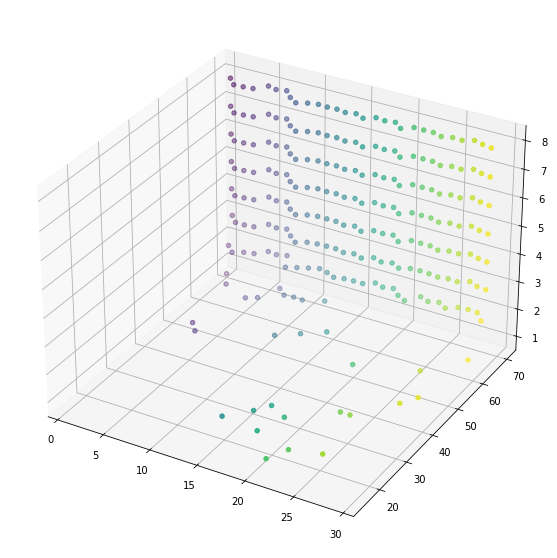

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdataset1, newdataset3, newdataset2, c = col)
#ax.plot(newdataset1, newdataset3, newdataset2)
plt.show()

In [38]:
col = np.arange(232)
#for i in range(0,46168) :
#    col[i] = ((col[i] % 199) +1)/20
col

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
46168%199